# MedNER
---  
  
Medikuntzako NER sistema gainbegiratu bat egingo da.

Horretarako, lehenik eta behin beharrezko liburutegiak inportatuko dira. Erabiliko da the Hugging Face Transformers liburutegia zeinak diseinatuta dagoen aurre-entrenatutako Transformer modeloak, BERT adibidez, erabiltzeko. Instalatzeko:


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Gainerako liburutegiak inportatuko dira:

In [ ]:
from transformers import BertModel, BertTokenizer, BertTokenizerFast, BertForTokenClassification
from transformers import AutoTokenizer, AutoModelForMaskedLM
import torch
from tqdm import tqdm
import torch.nn as nn
import spacy
import numpy as np
import random
import time
import os
import csv

Konprobatuko da notebook-a GPUan exekutatzen dagoela ("Running on cuda" inprimatu beharko luke).

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on {}".format(device))

Running on cuda


Datuak dituen direktoria erabiliko da:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd "/content/drive/MyDrive/universidad/4.CURSO/HP/PROIEKTUA/data"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/universidad/4.CURSO/HP/PROIEKTUA/data


## Datuak irakurri eta *train*, *dev* eta *test* partizioak egin

Anotatutako corpus guztia *corpus_pubtator.txt* fitxategian dago.  Datu hauek PubTator formatuan daude. Zehazki kasu bakoitza honela dago errepresentatuta:
  
```
PMID | t | Title text  
PMID | a | Abstract text    
PMID TAB StartIndex TAB EndIndex TAB MentionTextSegment TAB SemanticTypeID TAB EntityID
...
```

Lehenengo bi lerroek izenburuko eta laburpeneko testuak aurkezten dituzte (lerro-jauzirik eta tabulaziorik gabe testuan). Hurrengo lerroek entitateak aurkezten dituzte, lerro bakoitzeko bana. *StartIndex* eta *EndIndex* dokumentuaren testuan 0an oinarritutako karaktereen aurkibideak dira, Izenburua eta Laburpena kateatuz eraikiak, SPACE karaktere batez bereiziak. *MentionTextSegment* karaktere-posizio horien arteko benetako entitatea da. *EntityID* UMLS entitatearen id da (kontzeptua), eta *SemanticTypeID* entitatea UMLSen lotuta dagoen mota semantikoaren id da. UMLS entitate mota semantiko bati baino gehiagori lotuta badago, eremu honek komen arabera bereizitako zerrenda bat du ID mota guztiekin. 2017-AA bertsio aktiboan ez dauden UMLS kontzeptu guztiak *UnknownType* mota semantiko bereziari lotuta daude.  

Jarraian adibide bat azaltzen da:
```
25763772|t|DCTN4 as a modifier of chronic Pseudomonas aeruginosa infection in cystic fibrosis
25763772|a|Pseudomonas aeruginosa (Pa) infection in cystic fibrosis (CF) patients is associated with worse long-term pulmonary disease and shorter survival, and chronic Pa infection (CPA) is associated with reduced lung function, faster rate of lung decline, increased rates of exacerbations and shorter survival. By using exome sequencing and extreme phenotype design, it was recently shown that isoforms of dynactin 4 (DCTN4) may influence Pa infection in CF, leading to worse respiratory disease. The purpose of this study was to investigate the role of DCTN4 missense variants on Pa infection incidence, age at first Pa infection and chronic Pa infection incidence in a cohort of adult CF patients from a single centre. Polymerase chain reaction and direct sequencing were used to screen DNA samples for DCTN4 variants. A total of 121 adult CF patients from the Cochin Hospital CF centre have been included, all of them carrying two CFTR defects: 103 developed at least 1 pulmonary infection with Pa, and 68 patients of them had CPA. DCTN4 variants were identified in 24% (29/121) CF patients with Pa infection and in only 17% (3/18) CF patients with no Pa infection. Of the patients with CPA, 29% (20/68) had DCTN4 missense variants vs 23% (8/35) in patients without CPA. Interestingly, p.Tyr263Cys tend to be more frequently observed in CF patients with CPA than in patients without CPA (4/68 vs 0/35), and DCTN4 missense variants tend to be more frequent in male CF patients with CPA bearing two class II mutations than in male CF patients without CPA bearing two class II mutations (P = 0.06). Our observations reinforce that DCTN4 missense variants, especially p.Tyr263Cys, may be involved in the pathogenesis of CPA in male CF.
25763772        0       5       DCTN4   T116,T123    C4308010
25763772        23      63      chronic Pseudomonas aeruginosa infection        T047    C0854135
25763772        67      82      cystic fibrosis T047    C0010674
25763772        83      120     Pseudomonas aeruginosa (Pa) infection   T047    C0854135
...
```

Bestalde, *train*, *dev* eta *test* partizioak *corpus_pubtator_pmids_trng.txt, corpus_pubtator_pmids_dev.txt, corpus_pubtator_pmids_test.txt* fitxategietan daude.  Hauek dokumentuaren  %60, %20, %20-ko ausazko partizioak dituzte, hurrenez hurren. Bakoitzean zehazten dira dauden kasuen kodeak (PMID).

Beraz, partizioak egingo dira dokumentu bana izateko *train*, *dev* eta *test* kasuetarako. Horretarako:
1. Sortuko da fitxategi bana *train*, *dev* eta *test*-eko kasuak gordetzeko.
2. Irakurriko dira *corpus_pubtator_pmids_trng.txt, corpus_pubtator_pmids_dev.txt, corpus_pubtator_pmids_test.txt* fitxategiak. Irakurtzen den kode bakoitzeko *corpus_pubtator.txt* fitxategian  dagoen kasu hori hartuko da eta dagokion fitxategian (*train*, *dev* edo *test*) kopiatuko da.

### Aldagai orokorrak definitu direktorioak gordetzeko

In [ ]:
data_directory = "corpus_pubtator.txt"

train_directory = "corpus_pubtator_pmids_trng.txt"
dev_directory = "corpus_pubtator_pmids_dev.txt"
test_directory = "corpus_pubtator_pmids_test.txt"

train_def_directory = "corpus_pubtator_train.txt"
dev_def_directory = "corpus_pubtator_dev.txt"
test_def_directory = "corpus_pubtator_test.txt"

### Fitxategiak sortu

In [ ]:
def createFile(path):
    if not os.path.exists(path):
        os.makedirs(os.path.dirname(path), exist_ok=True)

def createDirectory(path):
    if not os.path.exists(path):
        os.mkdir(path)

createFile("./data" + train_def_directory)
createFile("./data" + dev_def_directory)
createFile("./data" + test_def_directory)

### Fitxategiak idatzi

In [ ]:
def idatzi_kasua(write_directory, line):
  with open(write_directory, "a") as f:
    f.write(line)

### Fitxategiak irakurri

In [ ]:
def aurkitu_kasua(data_directory,write_directory, code):
  aurkitu = False
  with open(data_directory) as file:
        for line in file:
          if  "|" in line:
            lines = line.split("|")
          else:
            lines = line.split("\t")
            
          if lines[0] == code:
            aurkitu = True
            idatzi_kasua(write_directory, line)
          elif aurkitu:
            break

def read_makePartitions_txt(filename, write_directory):
    
    """ Read input one by line """
    with open(filename) as file:
        for line in file:
            aurkitu_kasua(data_directory, write_directory, line.strip())

In [ ]:
read_makePartitions_txt(train_directory, train_def_directory)
read_makePartitions_txt(dev_directory, dev_def_directory)
read_makePartitions_txt(test_directory, test_def_directory)

## Z1
MedMentions corpusa erabiliz NER sistema orokor bat
entrenatu, termino bat UMLSkoa den, hau da, osasunarekin zerikusia ote duen
jakiteko. Hau da, terminoak identifikatu, klase bakarra irteeran dagoelarik
(Medikuntzkoa edo MED).  Horretarako BERT desberdinak doituko (fine-tunning) dira.

### BIO etiketatzea
Z1 betetzeko, partizioak eginda daudela, hauetan dauden kasuak MedMentions-eko formatutik BIO etiketatzera egokituko dira. Aurrerago erabiliko diren ereduek formatu hau eskatzen dutelako.     


Etiketa bakarra egongo da, MED dena. Beraz, tokena entitate baten hasiera baldin bada B-MED etiketa jasoko du. I-MED izango du aldiz, entitatearen barruan baldin badago eta 0 ez bada entitate bat. Jarraian adibide bat aurkezten da:

```
[DCTN4] as a modifier of [chronic Pseudomonas aeruginosa infection] in [cystic fibrosis]

B-MED O O O O B-MED I-MED I-MED I-MED O B-MED I-MED
```

Lehenik eta behin fitxategi berriak sortuko dira *train*, *dev* eta *test* partizio bakoitzeko kasuak BIO etiketatzean gordetzeko.

In [ ]:
#Aldagai orokorrak
train_BIO_directory_Z1 = "corpus_BIO_train_Z1.txt"
dev_BIO_directory_Z1 = "corpus_BIO_dev_Z1.txt"
test_BIO_directory_Z1 = "corpus_BIO_test_Z1.txt"

#sortu fitxategiak
createFile("./" + train_BIO_directory_Z1)
createFile("./" + dev_BIO_directory_Z1)
createFile("./" + test_BIO_directory_Z1)

Orain aurretik sortu diren fitxategiak (corpus_pubtator_train.txt, corpus_pubtator_test.txt eta corpus_pubtator_dev.txt) irakurriko dira eta etiketatuko dira. Horretarako kasu bakoitzeko lehenengo bi lerroak irakurriko dira izenburua eta abstracta direnak, hain zuzen ere.  Hasieran token guztiak 0 moduan etiketatuko dira eta gero, B-MED jarriko da baldin eta entitate baten hasiera bada eta I-MED entitate baten parte bada. Horretarako, hurrengo lerroak begiratuko dira eta aztertuko da *StartIndex*  eta *EndIndex* jakiteko zeintzuk diren entitateak.

Bestalde, *SpaCy*-ko tokenizatzailea erabiliko da titulua eta abstracta tokenizatzeko. Gainera, *MentionTextSegment* (entitatea adierazten duena) hainbat hitzez osatuta egon daitekenez baita erabiliko da hau tokenizatzeko.

SpaCy-ko inportak egin eta tokenizatzailea definituko da:

In [ ]:
# spaCy-ko lematizatzailea behar dugu baina gainerakoa kenduko dugu analisi-katetik
nlp = spacy.load('en_core_web_sm', disable=['tagger,ner,parser'])
nlp.remove_pipe('tagger')
nlp.remove_pipe('ner')
nlp.remove_pipe('parser');

def tokenize(text):
  new_text = ""
  for t in text:
    if t == " ":
      new_text += "  "
    else:
      new_text += t

  spacy_tokens=[]
  spacy_tokens.extend([token.text for token in nlp(new_text)])
  return spacy_tokens


Hurrengo funtzioek fitxategi bakoitza irakurri eta BIO moduan etiketatu egiten dute klase bat daukagula bakarrik. Horretarako hainbat gauza kontutan hartzen dira:

*   Entitate bat bi aldiz etiketatu egon daiteke modu desberdinetan. Adibidez, *olive orchards* agertzen da kasu bateko abstract-ean. Kasu horretan, *olive*  eta *olive orchards* daude entitate moduan etiketatuta. Beraz, biak sartu behar dira. Kasu honetan, eskatzen du *olive orchards* entitatea sortzea eta sartzea, *olive* entitatearen ondoren. 
* Aurrekoaren kontrakoa gerta daiteke. Entitate bat hainbat tokenez osatuta dagoenean batzuetan horietako token bat baita dago etiketatuta entitate indibidual moduan. Adibidez, *melanoma  tumors* agertzen da kasu bateko abstract-ean. Kasu horretan, *melanoma tumors*  eta *tumors* daude entitate moduan etiketatuta. Beraz, biak sartu behar dira. Kasu honetan, eskatzen du *tumors* entitatea sortzea eta  sartzea, *melanoma tumors* entitatearen ondoren. 




In [ ]:
def idatzi_entitateak(entitate_guztiak, write_directory):
  for entitatea in entitate_guztiak:
    if entitatea[0] != " ":
      text = entitatea[0] + "\t" + entitatea[3] + "\n"
      idatzi_kasua(write_directory, text)
  saltoa = "      \n" #lerro saltoa
  idatzi_kasua(write_directory, saltoa)


In [ ]:
def readBIO_Z1_txt(filename, write_directory):
    
    """ Read input one by line """
    with open(filename) as file:
        lines = "" #it  will contain the tittle and abstract
        entitate_guztiak = []
        cont = 0
        cont_len = 0
        for line in file:
          if  "|" in line:
            if cont % 2 == 0 and cont != 0:
              #idatzi
              idatzi_entitateak(entitate_guztiak, write_directory)
              entitate_guztiak = []
              lines = ""           
              cont_len = 0   
            cont += 1
            text_ta = (line.split("|")[2]).split("\n")[0]
            tokenizatu_text_ta = tokenize(text_ta+ " ")
            for t in tokenizatu_text_ta:
              entitate_guztiak.append([t,cont_len , cont_len+len(t) ,"O"])
              cont_len += len(t)
            lines += text_ta + " "
          else:
            desk = line.split("\t")
            index_start = int(desk[1])
            index_end = int(desk[2])
            entitate = lines[index_start:index_end]
            entitate_tokenizatu = tokenize(entitate)
            first = True
            for ent in entitate_tokenizatu:
              if first:
                if ent != " ":
                  try:
                    index = entitate_guztiak.index([ent,index_start, index_start + len(ent), "O"])
                    entitate_guztiak[index] = [ent,index_start, index_start + len(ent), "B-MED"]
                    index_start += len(ent)
                    first = False
                  except:
                    index += 1
                    entitate_guztiak.insert(index, [ent, len(entitate_guztiak[index-1][0]), len(entitate_guztiak[index-1][0])+len(ent), "B-MED"])
                    index_start += len(ent)
                    first = False
                else:
                  index_start += 1
              elif ent != " ":
                try:
                  index = entitate_guztiak.index([ent,index_start, index_start +len(ent), "O"])
                  entitate_guztiak[index] = [ent,index_start, index_start +len(ent), "I-MED"]
                  index_start += len(ent)
                except:
                  index += 1
                  entitate_guztiak.insert(index, [ent, len(entitate_guztiak[index-1][0]), len(entitate_guztiak[index-1][0])+len(ent), "I-MED"])
                  index_start += len(ent)
              else:
                index_start += 1
        #azkena
        idatzi_entitateak(entitate_guztiak, write_directory)

In [ ]:
readBIO_Z1_txt(dev_def_directory ,dev_BIO_directory_Z1)
readBIO_Z1_txt(test_def_directory ,test_BIO_directory_Z1)
readBIO_Z1_txt(train_def_directory ,train_BIO_directory_Z1)

/usr/local/lib/python3.8/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


### BIO moduan etiketatutako datuak irakurri

Jarrain definituko dira funtzio batzuk aurretik etiketatu diren datuak irakurtzeko. Funtzio honek datuak irakurri eta esaldiz osatutako lista bat sortzen du.  Kasu bakoitza banatzeko lerro saltoa erabiliko da. Esaldi bakoitza tuplas osatutako lista bat da eta tupla bakoitza bi elementuz osatuta dago: hitza eta etiketa (O,B,I).


In [ ]:
def read_txt(filename):    
    sentences=[]
    sentence=[]
    with open(filename) as file:
        for line in file:
            cols=line.rstrip().split("\t")
            if len(cols) < 2:
                if len(sentence) > 0:
                    sentences.append(sentence)
                sentence=[]
                continue
                
            word=cols[0]
            tag=cols[1]
            
            sentence.append((word, tag))
            
        if len(sentence) > 0:
            sentences.append(sentence)
            
    return sentences

In [ ]:
trainDataZ1 = read_txt(train_BIO_directory_Z1)
devDataZ1 = read_txt(dev_BIO_directory_Z1)
testDataZ1 = read_txt(test_BIO_directory_Z1)

Ikusiko da egitura egokia dela, hau da, aurretik aipatuta egitura duela:

In [ ]:
print(trainDataZ1[0])
print(len(trainDataZ1))
print(len(devDataZ1))
print(len(testDataZ1))

[('An', 'O'), ('S116R', 'B-MED'), ('Phosphorylation', 'I-MED'), ('Site', 'I-MED'), ('Mutation', 'B-MED'), ('in', 'O'), ('Human', 'B-MED'), ('Fibroblast', 'B-MED'), ('Growth', 'I-MED'), ('Factor-1', 'I-MED'), ('Differentially', 'O'), ('Affects', 'O'), ('Mitogenic', 'B-MED'), ('and', 'O'), ('Glucose', 'B-MED'), ('-', 'I-MED'), ('Lowering', 'I-MED'), ('Activities', 'I-MED'), ('Fibroblast', 'B-MED'), ('growth', 'I-MED'), ('factor-1', 'I-MED'), ('(', 'O'), ('FGF-1', 'B-MED'), (')', 'O'), (',', 'O'), ('a', 'O'), ('potent', 'O'), ('human', 'B-MED'), ('mitogen', 'B-MED'), ('and', 'O'), ('insulin', 'B-MED'), ('sensitizer', 'O'), (',', 'O'), ('signals', 'B-MED'), ('through', 'O'), ('both', 'O'), ('tyrosine', 'B-MED'), ('kinase', 'I-MED'), ('receptor', 'I-MED'), ('-mediated', 'O'), ('autocrine', 'B-MED'), ('/', 'O'), ('paracrine', 'B-MED'), ('pathways', 'I-MED'), ('as', 'O'), ('well', 'O'), ('as', 'O'), ('a', 'O'), ('nuclear', 'B-MED'), ('intracrine', 'B-MED'), ('pathway', 'I-MED'), ('.', 'O'), (

Orain, entrenamendu-datuetan jaso ahal diren etiketa guztiei indize bat eman zaie, hurrengo datu-egitura sortuz: hiztegi bat etiketekin eta indizearekin, eta alderantzizko hiztegia indezeekin eta etiketekin.


In [ ]:
def get_tag_vocab(sentences):
    tags={}
    tid=0
    for sentence in sentences:
        for word, tag in sentence:
            if tag not in tags:
                tags[tag]=tid
                tid+=1
    rev_tags={}
    for t in tags:
      rev_tags[tags[t]]=t

    return tags,rev_tags

tag_vocab,rev_tags=get_tag_vocab(trainDataZ1)

print(tag_vocab)
print(rev_tags)
print(rev_tags[0])

{'O': 0, 'B-MED': 1, 'I-MED': 2}
{0: 'O', 1: 'B-MED', 2: 'I-MED'}
O



###BERT-base sekuentzia-etiketatzailea definitzea

Kasu honetan, tokenizatzailea eta transformerraren parametroak deskargatuko dira Transformers liburutegitik. Modeloak "model_name" zehatz batekin gordetzen dira.

Mini-batchak tokenizatzailearen arabera antolatzen dira.

Hugging Face (BertForTokenClassification) modeloa erabili beharrean, BERTek NERrako sekuentzia-sailkatzaile gisa funtzionatzeko kodea sartuko da.

NER datasetek hitz bakoitzari BIO-formatuko etiketa bat ematen dion bitartean, BERT tokenizatzaileak hitz horiek token askotan bana ditzake. Horrela, etiketak egokitu behar dira sekuentzia tokenizatuaren luzera berriarekin bat etortzeko. Hau egiteko modu asko daude: jatorrizko hitzaren BIO etiketa dagozkion hitz guztiei eslei dakieke, edo, bestela, BIO etiketa lehenengo azpihitzari esleitu, eta, aldi berean, etiketa berezi bat (-100) esleitu hitz horri dagozkion gainerako azpihitzei. Lehengo aukera erabiliko da, eta etiketak "luzatuko" dira jatorrizko hitz bakoitzari dagozkion azpihitz guztiei BIO etiketa bera emanez.

Hona adibide bat:
```
input in sentences (3 tokens): 

                     words: Hello San Sebastian! 
                     tags:  O     B   I

input as organized for batch_x and batch_adjusted_tags: 

                subwords:    [CLS] Hel #lo San Sebast #ian ! [SEP] [PAD] ... [PAD]
                .word_ids(): None  0   0   1   2      2    2 None  None      None
                tags:        -1    O   O   B   I      I    I -1    -1        -1    
                
                Note that -1 tags will be ignored when computing loss
```


In [ ]:
class BERTSequenceLabeler(nn.Module):

    
    def __init__(self, params):
        super().__init__()
    
        self.model_name=params["model_name"]
        if self.model_name == "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext" or self.model_name == "dmis-lab/biobert-v1.1":
          self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
          self.bert = AutoModelForMaskedLM.from_pretrained(self.model_name)
        else:
          self.tokenizer = BertTokenizerFast.from_pretrained(self.model_name, do_lower_case=params["doLowerCase"], do_basic_tokenize=False)
          self.bert = BertModel.from_pretrained(self.model_name)
        self.num_labels = params["label_length"]

        self.fc = nn.Linear(params["embedding_size"], self.num_labels)

    def forward(self, batch_x): 
    
        bert_output = self.bert(input_ids=batch_x["input_ids"],
                         attention_mask=batch_x["attention_mask"],
                         token_type_ids=batch_x["token_type_ids"],
                         output_hidden_states=True)

        bert_hidden_states = bert_output['hidden_states']

        # Note that the hidden states of all layers are returned, hence the use of -1 to access the states of the top layer
        out = bert_hidden_states[-1]
        out = self.fc(out)

        return out.squeeze()

    def get_batches(self, all_data, batch_size=32, max_toks=512):
            
        """ Get batches for input x, y data, with data tokenized according to the BERT tokenizer 
            (and limited to a maximum number of BERT tokens """

        batches_x=[]
        batches_y=[]
        
        for i in range(0, len(all_data), batch_size):

            current_batch=[]

            data=all_data[i:i+batch_size]       # returns a list of word,tag pairs
            def extract_words(item):            # returns a list of words
              return [word for word,tag in item]
            def extract_tags(item):             # returns a list of tags
              return [tag for word,tag in item]
            sentences = [extract_words(item) for item in data]

            # is_split_in_words=True, Tokenizer assumes input is already tokenized into words
            # as the tokenizer returns subwords, the `batch_x.word_ids(i)` method returns the original word index of each subword 
            batch_x = self.tokenizer(sentences, padding=True, truncation=True, return_tensors="pt", is_split_into_words=True)
            

            batch_adjusted_tags = []
            for i, item in enumerate(data):    
              word_ids = batch_x.word_ids(i)     
              sentence = extract_words(item)
              tags = extract_tags(item)
              def get_tag_from_id(id,tags):
                if id==None:
                  return -1
                elif not tags[id] in tag_vocab.keys():
                  return tag_vocab['O'] #itzuli O
                else:
                  return tag_vocab[tags[id]]
              adjusted_tags = [get_tag_from_id(id,tags) for id in word_ids]
              batch_adjusted_tags.append(adjusted_tags)

            mapped_ids = batch_x.word_ids()

            batches_x.append(batch_x.to(device))
            batches_y.append(torch.LongTensor(batch_adjusted_tags).to(device))
            
        return batches_x, batches_y

### Ebaluazioa
 **Evaluation** funtzioa definituko da. Funtzioak ez du accuracy kalkulatzen token bakoitzeko metrika hau ona ez baita. Honek ematen dituen emaitzak oso altuak dira gure datuetan ```O``` etiketa asko daudelako. Beraz, F1 metrika erabiliko da. Honek tokenen gainean egin beharrean entitate motadunen
gainean egiten du. Honela, ez dira emaitz hain altuak lortzen baina emaitzak errealistagoak dira ```O``` etiketak ez direlako zuzenean kontutan hartzen.  F1 metrikak *precision* eta *recall* metriken batezbesteko harmonikoa kalkulatzen du. Bi metrika horiek alderantzizko proportzionalak direnez F1 metrikaren bidez kalkulatu dezakegu *precision* eta *recall* metriken balioak zein onak diren. *precision* eta *recall* metriken definizioa eta kalkulua hurrengo argazkian ikus daiteke:

$\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad$
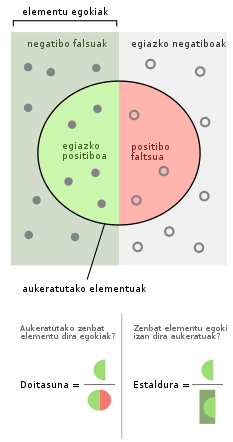

$\quad\quad\quad\quad\quad\quad\quad\quad$ **1.irudia.** *Precision* eta *recall* metriken definizioa eta kalkulatu

Bestalde, F1 ebaluatzen denean bi gauza kontutan hartu behar dira:

1.  Nola definitzen dugu sekuentziako hitz baterako aurreikusitako etiketa, gure ereduak azpi-hitzetarako etiketak baino ez badizkigu ematen? Lehen azpi-hitzerako aurreikusitako etiketa erabiliko dugu hitz osorako etiketa gisa, hitz baten ondorengo azpi-hitzen etiketak alde batera utzita.
 
2.   Nola kalkulatzen dugu entitateen doitasuna eta estaldura? Entitateen kointzidentzia zehatza erabiliko da.  

F1 formula honela kalkulatzen da:   $F1 = 2 \frac{precision * recall}{precision + recall}$




 

In [ ]:
def evaluateF1(model, x, y):
    model.eval()
    word_y = []
    word_y_preds = []
    with torch.no_grad():
        for x, y in zip(x, y):
            y_preds=model.forward(x)
            y_preds=torch.argmax(y_preds, dim=2)
            # Convert tags in subword tokens back to word-level sequences, 
            # extracting predicted tag from prediction for first subword of each word
            for i in range(len(y_preds)):
              word_ids = x.word_ids(i)
              curr_y = []
              curr_y_preds = []
              prev_id = -100
              assert len(y_preds[i])==len(y[i]) and len(y_preds[i]) == len(word_ids)
              for id, y_label, y_preds_label in zip(word_ids, y[i], y_preds[i]):
                if id is not None and id!=prev_id:
                  prev_id = id
                  y_label = int(y_label)
                  y_preds_label = int(y_preds_label)
                  curr_y.append(rev_tags[y_label])
                  curr_y_preds.append(rev_tags[y_preds_label])
              word_y.append(curr_y) 
              word_y_preds.append(curr_y_preds)

    global WORD_Y_PREDS
    WORD_Y_PREDS = word_y_preds
    # compute precision, recall and F1 on the word level
    precision, recall, F1 = calculateF1(word_y, word_y_preds)
    return precision, recall, F1


def get_predicted_labels():
  return WORD_Y_PREDS

def calculateF1(gold_sequences, predicted_sequences):
    
    """ Function to calculate the precision, recall and F-score over labeled chunks in the gold and predicted
    input sequences.  Each input parameter contains a list of label sequences (one label for each word in the
    sentence). In the following example, `gold_sequences` and `predicted_sequences` both contain two sentences
    (the first has 7 words/tags, and the second has 3 words/tags):
    
    gold_sequences=[["B-PER", "I-PER", "O", "O", "O", "O", "B-ORG"], ["O", "O", "O"]]
    predicted_sequences=[["B-PER", "O", "O", "O", "B-PER", "O", "B-ORG"], ["O", "O", "O"]]
    
    Returns tuple of (precision, recall, F1-score)
            for the example precision would be 1/3, recall 1/2, and F1 0.4
    
    """
    assert(len(gold_sequences) == len(predicted_sequences))
    precision, precision_total, recall, recall_total = 0,0,0,0
    for i in range(len(gold_sequences)):
      for j in range(len(gold_sequences[i])):
        if "B-" in gold_sequences[i][j]:
          recall_total += 1

        if "-"  in predicted_sequences[i][j]:
          if "B-" in predicted_sequences[i][j]:
            precision_total += 1
          if gold_sequences[i][j] == predicted_sequences[i][j]:
            if j!= len(gold_sequences[i])-1:
              if "I" not in gold_sequences[i][j+1]:
                precision += 1
                recall += 1
            else:
              precision += 1
              recall += 1
    if precision_total == 0:
      precision = 0
    else:
      precision /= precision_total
    
    if recall_total == 0:
      recall = 0
    else:
      recall /= recall_total

    if precision + recall == 0:
      F1 = 0
    else:
      F1 = (2 * precision * recall)/(precision + recall)
    return precision, recall, F1




### BERT orokorra doitu
Datuak irakurrita, prozesatuta eta mini-batchak eta ebaluazio funtzioak ditugula. Aurre-entrenatutako BERT eredu orokor bat kargatuko da NER etiketatzea egiteko eta traineko datuekin doitu egingo da gure probleman hobeto egiten ikasteko. Gero dev-ekin hainbat aldiz konprobatuko da ondo egiten dela eta azkenik, test-ekin ebaluatuko da.

In [ ]:
def train_and_evaluate(bert_model_name, model_filename, train_data, dev_data, label_length, embedding_size=768, doLowerCase=None, freezeBert=False, num_epochs=5): # eneko freeze bert

  start_time=time.time()
  bert_model = BERTSequenceLabeler(params={"doLowerCase": doLowerCase, "model_name": bert_model_name, "embedding_size":embedding_size, "label_length": label_length, "freezeBert": freezeBert})
  bert_model.to(device)
  batch_x, batch_y = bert_model.get_batches(train_data)
  dev_batch_x, dev_batch_y = bert_model.get_batches(dev_data)
  optimizer = torch.optim.Adam(bert_model.parameters(), lr=1e-5)
  cross_entropy=nn.CrossEntropyLoss(ignore_index=-1)

  best_dev_acc = 0.

  for epoch in range(num_epochs):
      bert_model.train()

      # Train
      for x, y in tqdm(list(zip(batch_x, batch_y))):
          y_pred = bert_model.forward(x)
          loss = cross_entropy(y_pred.view(-1, bert_model.num_labels), y.view(-1))
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
      
      # Evaluate
      bert_model.eval()
      losses = []
      for x,y in tqdm(list(zip(dev_batch_x, dev_batch_y))):
        y_pred = bert_model.forward(x)
        loss = cross_entropy(y_pred.view(-1, bert_model.num_labels), y.view(-1)).item()
        losses.append(loss)
      print('Avg dev loss: %.3f' % torch.mean(torch.tensor(losses)))

      dev_precision, dev_recall, dev_F1 = evaluateF1(bert_model, dev_batch_x, dev_batch_y)#F1 erabili
      if epoch % 1 == 0:
          print("Epoch %s, dev accuracy: %.3f,%.3f,%.3f" % (epoch, dev_precision, dev_recall, dev_F1))
          if dev_F1 > best_dev_acc:
              torch.save(bert_model.state_dict(), model_filename)
              best_dev_acc = dev_F1

  print("\nBest Performing Model achieves dev accuracy of :  %.3f,%.3f,%.3f" % (dev_precision, dev_recall, dev_F1))
  print("Time: %.3f seconds ---" % (time.time() - start_time))

Tamaina desberdinetako BERT-ak daude, geruza kopuru desberdinekin (2, 4, 6, 8, 10) eta dimentsio desberdinekin (128, 256, 512). Zenbat eta txikiago izan azkarrago entrenatzen da baina lortzen diren emaitzak txarragoak dira. Beraz, erabaki da ez oso txikia eta ez oso handia den eredu bat erabiltzea. Modu honetan lortzen diren emaitzak nahiko onak izango dira denbora nahiko txikian. Zehazki, *bert-small* erabili da ezkutuko dimentsioa H=512 dena, 4 ezkutuko geruza L=4 eta 8 atentzio geruza A=8 dituena.

Jarraian modelo hori erabili da epoch bakoitzeko *precision*, *recall* eta *F1* lortzen direlarik. F1, aipatu bezala, bi metrikak erlazionatzen dituenez hau erabili hau *best_dev_acc* bezala. 

In [ ]:
train_and_evaluate("google/bert_uncased_L-4_H-512_A-8", "ner-bert-small" , trainDataZ1, devDataZ1, max(tag_vocab.values()) + 1, embedding_size=512, doLowerCase=True, num_epochs=50)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/383 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/bert_uncased_L-4_H-512_A-8 were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 28/28 [00:01<00:00, 14.31it/s]


Avg dev loss: 0.454
Epoch 0, dev accuracy: 0.700,0.709,0.704


100%|██████████| 28/28 [00:02<00:00, 13.87it/s]


Avg dev loss: 0.387
Epoch 1, dev accuracy: 0.782,0.739,0.760


100%|██████████| 28/28 [00:02<00:00, 13.90it/s]


Avg dev loss: 0.362
Epoch 2, dev accuracy: 0.785,0.760,0.772


100%|██████████| 28/28 [00:02<00:00, 13.63it/s]


Avg dev loss: 0.350
Epoch 3, dev accuracy: 0.792,0.774,0.783


100%|██████████| 28/28 [00:02<00:00, 13.35it/s]


Avg dev loss: 0.342
Epoch 4, dev accuracy: 0.792,0.780,0.786


100%|██████████| 28/28 [00:02<00:00, 13.11it/s]


Avg dev loss: 0.337
Epoch 5, dev accuracy: 0.799,0.783,0.791


100%|██████████| 28/28 [00:02<00:00, 13.14it/s]


Avg dev loss: 0.334
Epoch 6, dev accuracy: 0.801,0.788,0.795


100%|██████████| 28/28 [00:02<00:00, 12.98it/s]


Avg dev loss: 0.330
Epoch 7, dev accuracy: 0.798,0.790,0.794


100%|██████████| 28/28 [00:02<00:00, 13.23it/s]


Avg dev loss: 0.329
Epoch 8, dev accuracy: 0.800,0.790,0.795


100%|██████████| 28/28 [00:02<00:00, 12.99it/s]


Avg dev loss: 0.328
Epoch 9, dev accuracy: 0.804,0.789,0.796


100%|██████████| 28/28 [00:02<00:00, 13.00it/s]


Avg dev loss: 0.327
Epoch 10, dev accuracy: 0.801,0.793,0.797


100%|██████████| 28/28 [00:02<00:00, 13.09it/s]


Avg dev loss: 0.327
Epoch 11, dev accuracy: 0.804,0.792,0.798


100%|██████████| 28/28 [00:02<00:00, 13.01it/s]


Avg dev loss: 0.328
Epoch 12, dev accuracy: 0.811,0.792,0.802


100%|██████████| 28/28 [00:02<00:00, 12.98it/s]


Avg dev loss: 0.328
Epoch 13, dev accuracy: 0.805,0.793,0.799


100%|██████████| 28/28 [00:02<00:00, 12.85it/s]


Avg dev loss: 0.330
Epoch 14, dev accuracy: 0.807,0.792,0.800


100%|██████████| 28/28 [00:02<00:00, 12.84it/s]


Avg dev loss: 0.331
Epoch 15, dev accuracy: 0.808,0.792,0.800


100%|██████████| 28/28 [00:02<00:00, 12.82it/s]


Avg dev loss: 0.332
Epoch 16, dev accuracy: 0.805,0.793,0.799


100%|██████████| 28/28 [00:02<00:00, 12.82it/s]


Avg dev loss: 0.334
Epoch 17, dev accuracy: 0.810,0.792,0.801


100%|██████████| 28/28 [00:02<00:00, 12.86it/s]


Avg dev loss: 0.337
Epoch 18, dev accuracy: 0.807,0.793,0.800


100%|██████████| 28/28 [00:02<00:00, 12.83it/s]


Avg dev loss: 0.340
Epoch 19, dev accuracy: 0.810,0.792,0.801


100%|██████████| 28/28 [00:02<00:00, 12.86it/s]


Avg dev loss: 0.340
Epoch 20, dev accuracy: 0.804,0.792,0.798


100%|██████████| 28/28 [00:02<00:00, 12.84it/s]


Avg dev loss: 0.344
Epoch 21, dev accuracy: 0.805,0.794,0.799


100%|██████████| 28/28 [00:02<00:00, 12.74it/s]


Avg dev loss: 0.347
Epoch 22, dev accuracy: 0.806,0.791,0.798


100%|██████████| 28/28 [00:02<00:00, 12.79it/s]


Avg dev loss: 0.351
Epoch 23, dev accuracy: 0.811,0.794,0.803


100%|██████████| 28/28 [00:02<00:00, 12.83it/s]


Avg dev loss: 0.352
Epoch 24, dev accuracy: 0.801,0.797,0.799


100%|██████████| 28/28 [00:02<00:00, 12.81it/s]


Avg dev loss: 0.353
Epoch 25, dev accuracy: 0.797,0.795,0.796


100%|██████████| 28/28 [00:02<00:00, 12.73it/s]


Avg dev loss: 0.358
Epoch 26, dev accuracy: 0.795,0.798,0.797


100%|██████████| 28/28 [00:02<00:00, 12.80it/s]


Avg dev loss: 0.359
Epoch 27, dev accuracy: 0.781,0.801,0.791


100%|██████████| 28/28 [00:02<00:00, 12.87it/s]


Avg dev loss: 0.363
Epoch 28, dev accuracy: 0.778,0.800,0.789


100%|██████████| 28/28 [00:02<00:00, 12.85it/s]


Avg dev loss: 0.366
Epoch 29, dev accuracy: 0.766,0.799,0.782


100%|██████████| 28/28 [00:02<00:00, 12.73it/s]


Avg dev loss: 0.369
Epoch 30, dev accuracy: 0.776,0.796,0.786


100%|██████████| 28/28 [00:02<00:00, 12.89it/s]


Avg dev loss: 0.374
Epoch 31, dev accuracy: 0.768,0.795,0.782


100%|██████████| 28/28 [00:02<00:00, 12.86it/s]


Avg dev loss: 0.378
Epoch 32, dev accuracy: 0.775,0.794,0.785


100%|██████████| 28/28 [00:02<00:00, 12.86it/s]


Avg dev loss: 0.383
Epoch 33, dev accuracy: 0.794,0.785,0.790


100%|██████████| 28/28 [00:02<00:00, 12.89it/s]


Avg dev loss: 0.387
Epoch 34, dev accuracy: 0.787,0.787,0.787


100%|██████████| 28/28 [00:02<00:00, 12.96it/s]


Avg dev loss: 0.392
Epoch 35, dev accuracy: 0.788,0.788,0.788


100%|██████████| 28/28 [00:02<00:00, 12.87it/s]


Avg dev loss: 0.395
Epoch 36, dev accuracy: 0.782,0.789,0.785


100%|██████████| 28/28 [00:02<00:00, 12.73it/s]


Avg dev loss: 0.399
Epoch 37, dev accuracy: 0.782,0.790,0.786


100%|██████████| 28/28 [00:02<00:00, 12.74it/s]


Avg dev loss: 0.401
Epoch 38, dev accuracy: 0.798,0.781,0.789


100%|██████████| 28/28 [00:02<00:00, 12.76it/s]


Avg dev loss: 0.407
Epoch 39, dev accuracy: 0.788,0.793,0.791


100%|██████████| 28/28 [00:02<00:00, 12.83it/s]


Avg dev loss: 0.413
Epoch 40, dev accuracy: 0.805,0.783,0.794


100%|██████████| 28/28 [00:02<00:00, 12.85it/s]


Avg dev loss: 0.418
Epoch 41, dev accuracy: 0.812,0.776,0.793


100%|██████████| 28/28 [00:02<00:00, 12.85it/s]


Avg dev loss: 0.422
Epoch 42, dev accuracy: 0.812,0.777,0.794


100%|██████████| 28/28 [00:02<00:00, 12.87it/s]


Avg dev loss: 0.420
Epoch 43, dev accuracy: 0.796,0.783,0.789


100%|██████████| 28/28 [00:02<00:00, 12.82it/s]


Avg dev loss: 0.430
Epoch 44, dev accuracy: 0.813,0.774,0.793


100%|██████████| 28/28 [00:02<00:00, 12.80it/s]


Avg dev loss: 0.433
Epoch 45, dev accuracy: 0.813,0.779,0.796


100%|██████████| 28/28 [00:02<00:00, 12.87it/s]


Avg dev loss: 0.439
Epoch 46, dev accuracy: 0.818,0.773,0.795


100%|██████████| 28/28 [00:02<00:00, 12.80it/s]


Avg dev loss: 0.447
Epoch 47, dev accuracy: 0.828,0.771,0.799


100%|██████████| 28/28 [00:02<00:00, 12.77it/s]


Avg dev loss: 0.462
Epoch 48, dev accuracy: 0.843,0.766,0.803


100%|██████████| 28/28 [00:02<00:00, 12.82it/s]


Avg dev loss: 0.468
Epoch 49, dev accuracy: 0.849,0.766,0.805

Best Performing Model achieves dev accuracy of :  0.849,0.766,0.805
Time: 1364.229 seconds ---


Azkenik, test-ean probatuko dugu gure modelo hoberena. Horretarako:  


1.   Aurre-entrenatutako modeloa hasieratuko dugu aurretik egin dugun moduan.
2.   Parametroak berridatziko ditugu gordetako modeloa erabiliz,
3. Gure modeloa ebaluatuko dugu test-eko datuak hartuz. Metrikak *precision*, *recall* eta *F1* dira hurrenez hurren.


In [ ]:
bert=BERTSequenceLabeler(params={"doLowerCase": True, "model_name": "google/bert_uncased_L-4_H-512_A-8", "embedding_size":512, "label_length": max(tag_vocab.values())+1})
bert.to(device)
bert.load_state_dict(torch.load('ner-bert-small'))

test_batch_x, test_batch_y = bert.get_batches(testDataZ1)
test_precision, test_recall, test_F1 = evaluateF1(bert, test_batch_x, test_batch_y)
print("\nBest Performing Model achieves test accuracy of :  %.3f,%.3f,%.3f" % (test_precision, test_recall, test_F1))

Some weights of the model checkpoint at google/bert_uncased_L-4_H-512_A-8 were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



Best Performing Model achieves test accuracy of :  0.848,0.766,0.805


### BERT espezializatuak doitu
BERT orokorrarekin lortu diren emaitzak hurrengoak dira: 0.848,0.766,0.805 (precision, recall eta F1). Emaitza nahiko onak dira nahiz era honek *biomedical* terminoen gainean ez entrenatuta egon. Hortaz, BERT espezializatuak probatuko dira asmatze-tasa handitzeko asmoarekin.  BERT hauek *biomedical* terminoen gainean aurre-entrenatuak egongo dira. Konkretuki bi BERT probatuko dira: BiomedNLP-PubMedBERT eta BioBERT.

Aurre-entrenatutako bi BERT horiek kargatuko dira NER etiketatzea egiteko eta traineko datuekin doitu egingo dira gure probleman hobeto egiten ikasteko. Gero dev-ekin hainbat aldiz konprobatuko da ondo egiten dutela eta azkenik, test-ekin ebaluatuko dira.



#### **BiomedNLP-PubMedBERT**
PubMedBERT aurre entrenatuta dago PubMed abstracten eta PubMedCentral artikuluen gainean. Jakinda gure *corpus*ak PubMed abstract-ak dituela, honek asmatze-tasa handitzea oso posiblea da.

PubMedBERTa eredu handia da. Izan ere, ezkutuko dimentsioa H=768 da, 12 ezkutuko geruza L=12 eta 12 atentzio geruza A=12 ditu. Beraz, hasiera batean batch size txiki batekin, 4, probatuko da eta ondoren defektuz dagoenarekin, 32, probatuko da. Modu honetan, ikusiko da batch size kopuruak nola eragin daukan baita emaitzetan.

Lehenik eta behin **batch size = 4**-rekin probatuko da:

In [ ]:
train_and_evaluate("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext", "ner-pub" , trainDataZ1, devDataZ1, max(tag_vocab.values()) + 1, embedding_size=768, doLowerCase=True, num_epochs=50)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 220/220 [00:16<00:00, 13.51it/s]


Avg dev loss: 0.307
Epoch 0, dev accuracy: 0.800,0.772,0.786


100%|██████████| 220/220 [00:16<00:00, 13.56it/s]


Avg dev loss: 0.292
Epoch 1, dev accuracy: 0.807,0.786,0.797


100%|██████████| 220/220 [00:16<00:00, 13.58it/s]


Avg dev loss: 0.292
Epoch 2, dev accuracy: 0.807,0.785,0.796


100%|██████████| 220/220 [00:16<00:00, 13.49it/s]


Avg dev loss: 0.296
Epoch 3, dev accuracy: 0.809,0.788,0.798


100%|██████████| 220/220 [00:16<00:00, 13.54it/s]


Avg dev loss: 0.304
Epoch 4, dev accuracy: 0.813,0.785,0.799


100%|██████████| 220/220 [00:16<00:00, 13.51it/s]


Avg dev loss: 0.316
Epoch 5, dev accuracy: 0.822,0.791,0.807


100%|██████████| 220/220 [00:16<00:00, 13.57it/s]


Avg dev loss: 0.333
Epoch 6, dev accuracy: 0.816,0.790,0.803


100%|██████████| 220/220 [00:16<00:00, 13.56it/s]


Avg dev loss: 0.345
Epoch 7, dev accuracy: 0.805,0.792,0.798


100%|██████████| 220/220 [00:16<00:00, 13.59it/s]


Avg dev loss: 0.361
Epoch 8, dev accuracy: 0.790,0.791,0.791


100%|██████████| 220/220 [00:16<00:00, 13.46it/s]


Avg dev loss: 0.386
Epoch 9, dev accuracy: 0.796,0.783,0.789


100%|██████████| 220/220 [00:16<00:00, 13.55it/s]


Avg dev loss: 0.403
Epoch 10, dev accuracy: 0.775,0.787,0.781


100%|██████████| 220/220 [00:16<00:00, 13.55it/s]


Avg dev loss: 0.429
Epoch 11, dev accuracy: 0.764,0.772,0.768


100%|██████████| 220/220 [00:16<00:00, 13.49it/s]


Avg dev loss: 0.438
Epoch 12, dev accuracy: 0.756,0.792,0.773


100%|██████████| 220/220 [00:16<00:00, 13.45it/s]


Avg dev loss: 0.444
Epoch 13, dev accuracy: 0.758,0.811,0.784


100%|██████████| 220/220 [00:16<00:00, 13.57it/s]


Avg dev loss: 0.459
Epoch 14, dev accuracy: 0.804,0.773,0.788


100%|██████████| 220/220 [00:16<00:00, 13.56it/s]


Avg dev loss: 0.486
Epoch 15, dev accuracy: 0.829,0.768,0.797


100%|██████████| 220/220 [00:16<00:00, 13.53it/s]


Avg dev loss: 0.504
Epoch 16, dev accuracy: 0.826,0.768,0.796


100%|██████████| 220/220 [00:16<00:00, 13.54it/s]


Avg dev loss: 0.507
Epoch 17, dev accuracy: 0.828,0.769,0.798


100%|██████████| 220/220 [00:16<00:00, 13.51it/s]


Avg dev loss: 0.532
Epoch 18, dev accuracy: 0.837,0.756,0.795


100%|██████████| 220/220 [00:16<00:00, 13.54it/s]


Avg dev loss: 0.543
Epoch 19, dev accuracy: 0.824,0.788,0.806


100%|██████████| 220/220 [00:16<00:00, 13.61it/s]


Avg dev loss: 0.558
Epoch 20, dev accuracy: 0.815,0.796,0.805


100%|██████████| 220/220 [00:16<00:00, 13.50it/s]


Avg dev loss: 0.570
Epoch 21, dev accuracy: 0.816,0.793,0.804


100%|██████████| 220/220 [00:16<00:00, 13.59it/s]


Avg dev loss: 0.597
Epoch 22, dev accuracy: 0.824,0.794,0.808


100%|██████████| 220/220 [00:16<00:00, 13.55it/s]


Avg dev loss: 0.607
Epoch 23, dev accuracy: 0.816,0.787,0.801


100%|██████████| 220/220 [00:16<00:00, 13.54it/s]


Avg dev loss: 0.626
Epoch 24, dev accuracy: 0.826,0.780,0.802


100%|██████████| 220/220 [00:16<00:00, 13.50it/s]


Avg dev loss: 0.639
Epoch 25, dev accuracy: 0.824,0.786,0.805


100%|██████████| 220/220 [00:16<00:00, 13.41it/s]


Avg dev loss: 0.634
Epoch 26, dev accuracy: 0.805,0.803,0.804


100%|██████████| 220/220 [00:16<00:00, 13.51it/s]


Avg dev loss: 0.665
Epoch 27, dev accuracy: 0.782,0.820,0.801


100%|██████████| 220/220 [00:16<00:00, 13.53it/s]


Avg dev loss: 0.688
Epoch 28, dev accuracy: 0.766,0.833,0.798


100%|██████████| 220/220 [00:16<00:00, 13.52it/s]


Avg dev loss: 0.694
Epoch 29, dev accuracy: 0.752,0.838,0.792


100%|██████████| 220/220 [00:16<00:00, 13.45it/s]


Avg dev loss: 0.729
Epoch 30, dev accuracy: 0.745,0.833,0.787


100%|██████████| 220/220 [00:16<00:00, 13.54it/s]


Avg dev loss: 0.756
Epoch 31, dev accuracy: 0.745,0.835,0.787


100%|██████████| 220/220 [00:16<00:00, 13.56it/s]


Avg dev loss: 0.770
Epoch 32, dev accuracy: 0.749,0.835,0.789


100%|██████████| 220/220 [00:16<00:00, 13.48it/s]


Avg dev loss: 0.763
Epoch 33, dev accuracy: 0.754,0.832,0.791


100%|██████████| 220/220 [00:16<00:00, 13.53it/s]


Avg dev loss: 0.778
Epoch 34, dev accuracy: 0.748,0.840,0.791


100%|██████████| 220/220 [00:16<00:00, 13.54it/s]


Avg dev loss: 0.812
Epoch 35, dev accuracy: 0.741,0.843,0.789


100%|██████████| 220/220 [00:16<00:00, 13.53it/s]


Avg dev loss: 0.788
Epoch 36, dev accuracy: 0.742,0.837,0.787


100%|██████████| 220/220 [00:16<00:00, 13.46it/s]


Avg dev loss: 0.800
Epoch 37, dev accuracy: 0.764,0.836,0.799


100%|██████████| 220/220 [00:16<00:00, 13.52it/s]


Avg dev loss: 0.815
Epoch 38, dev accuracy: 0.763,0.831,0.796


100%|██████████| 220/220 [00:16<00:00, 13.64it/s]


Avg dev loss: 0.796
Epoch 39, dev accuracy: 0.766,0.827,0.796


100%|██████████| 220/220 [00:16<00:00, 13.53it/s]


Avg dev loss: 0.799
Epoch 40, dev accuracy: 0.778,0.813,0.795


100%|██████████| 220/220 [00:16<00:00, 13.47it/s]


Avg dev loss: 0.819
Epoch 41, dev accuracy: 0.775,0.809,0.791


100%|██████████| 220/220 [00:16<00:00, 13.54it/s]


Avg dev loss: 0.837
Epoch 42, dev accuracy: 0.797,0.798,0.797


100%|██████████| 220/220 [00:16<00:00, 13.56it/s]


Avg dev loss: 0.844
Epoch 43, dev accuracy: 0.783,0.799,0.791


100%|██████████| 220/220 [00:16<00:00, 13.55it/s]


Avg dev loss: 0.835
Epoch 44, dev accuracy: 0.780,0.809,0.794


100%|██████████| 220/220 [00:16<00:00, 13.49it/s]


Avg dev loss: 0.837
Epoch 45, dev accuracy: 0.795,0.794,0.794


100%|██████████| 220/220 [00:16<00:00, 13.56it/s]


Avg dev loss: 0.836
Epoch 46, dev accuracy: 0.779,0.803,0.791


100%|██████████| 220/220 [00:16<00:00, 13.54it/s]


Avg dev loss: 0.840
Epoch 47, dev accuracy: 0.790,0.801,0.796


100%|██████████| 220/220 [00:16<00:00, 13.56it/s]


Avg dev loss: 0.859
Epoch 48, dev accuracy: 0.783,0.812,0.797


100%|██████████| 220/220 [00:16<00:00, 13.57it/s]


Avg dev loss: 0.849
Epoch 49, dev accuracy: 0.779,0.807,0.793

Best Performing Model achieves dev accuracy of :  0.779,0.807,0.793
Time: 9098.729 seconds ---


Azkenik, test-ean probatuko dugu gure modelo hoberena. Horretarako:  


1.   Aurre-entrenatutako modeloa hasieratuko dugu aurretik egin dugun moduan.
2.   Parametroak berridatziko ditugu gordetako modeloa erabiliz,
3. Gure modeloa ebaluatuko dugu test-eko datuak hartuz. Metrikak *precision*, *recall* eta *F1* dira hurrenez hurren.


In [ ]:
bert=BERTSequenceLabeler(params={"doLowerCase": True, "model_name": "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext", "embedding_size":768, "label_length": max(tag_vocab.values())+1})
bert.to(device)
bert.load_state_dict(torch.load("ner-pub"))

test_batch_x, test_batch_y = bert.get_batches(testDataZ1)
test_precision, test_recall, test_F1 = evaluateF1(bert, test_batch_x, test_batch_y)
print("\nBest Performing Model achieves test accuracy of :  %.3f,%.3f,%.3f" % (test_precision, test_recall, test_F1))

Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



Best Performing Model achieves test accuracy of :  0.823,0.796,0.809


'\ntrain_batch_x, train_batch_y = bert.get_batches(trainDataZ1)\ntrain_precision, train_recall, train_F1 = evaluateF1(bert, train_batch_x, train_batch_y)\nprint("\nBest Performing Model achieves test accuracy of :  %.3f,%.3f,%.3f" % (train_precision, train_recall, train_F1))\n\ndev_batch_x, dev_batch_y = bert.get_batches(devDataZ1)\ndev_precision, dev_recall, dev_F1 = evaluateF1(bert, dev_batch_x, dev_batch_y)\nprint("\nBest Performing Model achieves test accuracy of :  %.3f,%.3f,%.3f" % (dev_precision, dev_recall, dev_F1))\n'

Orain **batch_size = 32**-rekin probatuko da.

In [ ]:
train_and_evaluate("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext", "ner-pub1" , trainDataZ1, devDataZ1, max(tag_vocab.values()) + 1, embedding_size=768, doLowerCase=True, num_epochs=50)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 28/28 [00:03<00:00,  8.16it/s]


Avg dev loss: 0.356
Epoch 0, dev accuracy: 0.757,0.771,0.764


100%|██████████| 28/28 [00:03<00:00,  8.18it/s]


Avg dev loss: 0.317
Epoch 1, dev accuracy: 0.790,0.793,0.791


100%|██████████| 28/28 [00:03<00:00,  8.16it/s]


Avg dev loss: 0.305
Epoch 2, dev accuracy: 0.794,0.800,0.797


100%|██████████| 28/28 [00:03<00:00,  8.17it/s]


Avg dev loss: 0.298
Epoch 3, dev accuracy: 0.799,0.803,0.801


100%|██████████| 28/28 [00:03<00:00,  8.16it/s]


Avg dev loss: 0.294
Epoch 4, dev accuracy: 0.805,0.808,0.806


100%|██████████| 28/28 [00:03<00:00,  8.18it/s]


Avg dev loss: 0.293
Epoch 5, dev accuracy: 0.810,0.810,0.810


100%|██████████| 28/28 [00:03<00:00,  8.18it/s]


Avg dev loss: 0.292
Epoch 6, dev accuracy: 0.814,0.809,0.811


100%|██████████| 28/28 [00:03<00:00,  8.16it/s]


Avg dev loss: 0.293
Epoch 7, dev accuracy: 0.816,0.810,0.813


100%|██████████| 28/28 [00:03<00:00,  8.18it/s]


Avg dev loss: 0.293
Epoch 8, dev accuracy: 0.817,0.813,0.815


100%|██████████| 28/28 [00:03<00:00,  8.18it/s]


Avg dev loss: 0.294
Epoch 9, dev accuracy: 0.824,0.811,0.817


100%|██████████| 28/28 [00:03<00:00,  8.19it/s]


Avg dev loss: 0.295
Epoch 10, dev accuracy: 0.818,0.813,0.815


100%|██████████| 28/28 [00:03<00:00,  8.19it/s]


Avg dev loss: 0.299
Epoch 11, dev accuracy: 0.821,0.813,0.817


100%|██████████| 28/28 [00:03<00:00,  8.18it/s]


Avg dev loss: 0.302
Epoch 12, dev accuracy: 0.821,0.813,0.817


100%|██████████| 28/28 [00:03<00:00,  8.16it/s]


Avg dev loss: 0.306
Epoch 13, dev accuracy: 0.824,0.812,0.818


100%|██████████| 28/28 [00:03<00:00,  8.16it/s]


Avg dev loss: 0.311
Epoch 14, dev accuracy: 0.824,0.811,0.818


100%|██████████| 28/28 [00:03<00:00,  8.18it/s]


Avg dev loss: 0.312
Epoch 15, dev accuracy: 0.816,0.812,0.814


100%|██████████| 28/28 [00:03<00:00,  8.19it/s]


Avg dev loss: 0.318
Epoch 16, dev accuracy: 0.809,0.817,0.813


100%|██████████| 28/28 [00:03<00:00,  8.19it/s]


Avg dev loss: 0.316
Epoch 17, dev accuracy: 0.787,0.819,0.803


100%|██████████| 28/28 [00:03<00:00,  8.19it/s]


Avg dev loss: 0.324
Epoch 18, dev accuracy: 0.769,0.821,0.794


100%|██████████| 28/28 [00:03<00:00,  8.17it/s]


Avg dev loss: 0.330
Epoch 19, dev accuracy: 0.763,0.821,0.791


100%|██████████| 28/28 [00:03<00:00,  8.17it/s]


Avg dev loss: 0.336
Epoch 20, dev accuracy: 0.758,0.826,0.791


100%|██████████| 28/28 [00:03<00:00,  8.15it/s]


Avg dev loss: 0.343
Epoch 21, dev accuracy: 0.752,0.823,0.786


100%|██████████| 28/28 [00:03<00:00,  8.18it/s]


Avg dev loss: 0.351
Epoch 22, dev accuracy: 0.752,0.822,0.786


100%|██████████| 28/28 [00:03<00:00,  8.17it/s]


Avg dev loss: 0.355
Epoch 23, dev accuracy: 0.780,0.813,0.796


100%|██████████| 28/28 [00:03<00:00,  8.18it/s]


Avg dev loss: 0.365
Epoch 24, dev accuracy: 0.773,0.821,0.796


100%|██████████| 28/28 [00:03<00:00,  8.18it/s]


Avg dev loss: 0.371
Epoch 25, dev accuracy: 0.775,0.815,0.795


100%|██████████| 28/28 [00:03<00:00,  8.18it/s]


Avg dev loss: 0.384
Epoch 26, dev accuracy: 0.782,0.827,0.804


100%|██████████| 28/28 [00:03<00:00,  8.18it/s]


Avg dev loss: 0.395
Epoch 27, dev accuracy: 0.779,0.824,0.800


100%|██████████| 28/28 [00:03<00:00,  8.18it/s]


Avg dev loss: 0.392
Epoch 28, dev accuracy: 0.800,0.789,0.795


100%|██████████| 28/28 [00:03<00:00,  8.19it/s]


Avg dev loss: 0.395
Epoch 29, dev accuracy: 0.810,0.771,0.790


100%|██████████| 28/28 [00:03<00:00,  8.17it/s]


Avg dev loss: 0.403
Epoch 30, dev accuracy: 0.831,0.777,0.803


100%|██████████| 28/28 [00:03<00:00,  8.18it/s]


Avg dev loss: 0.424
Epoch 31, dev accuracy: 0.815,0.821,0.818


100%|██████████| 28/28 [00:03<00:00,  8.18it/s]


Avg dev loss: 0.434
Epoch 32, dev accuracy: 0.816,0.823,0.819


100%|██████████| 28/28 [00:03<00:00,  8.19it/s]


Avg dev loss: 0.435
Epoch 33, dev accuracy: 0.804,0.823,0.814


100%|██████████| 28/28 [00:03<00:00,  8.18it/s]


Avg dev loss: 0.419
Epoch 34, dev accuracy: 0.800,0.817,0.808


100%|██████████| 28/28 [00:03<00:00,  8.18it/s]


Avg dev loss: 0.434
Epoch 35, dev accuracy: 0.824,0.783,0.803


100%|██████████| 28/28 [00:03<00:00,  8.18it/s]


Avg dev loss: 0.450
Epoch 36, dev accuracy: 0.822,0.777,0.799


100%|██████████| 28/28 [00:03<00:00,  8.19it/s]


Avg dev loss: 0.449
Epoch 37, dev accuracy: 0.828,0.781,0.804


100%|██████████| 28/28 [00:03<00:00,  8.16it/s]


Avg dev loss: 0.463
Epoch 38, dev accuracy: 0.831,0.776,0.803


100%|██████████| 28/28 [00:03<00:00,  8.16it/s]


Avg dev loss: 0.463
Epoch 39, dev accuracy: 0.818,0.782,0.800


100%|██████████| 28/28 [00:03<00:00,  8.15it/s]


Avg dev loss: 0.469
Epoch 40, dev accuracy: 0.819,0.796,0.807


100%|██████████| 28/28 [00:03<00:00,  8.18it/s]


Avg dev loss: 0.487
Epoch 41, dev accuracy: 0.797,0.829,0.813


100%|██████████| 28/28 [00:03<00:00,  8.19it/s]


Avg dev loss: 0.492
Epoch 42, dev accuracy: 0.789,0.834,0.811


100%|██████████| 28/28 [00:03<00:00,  8.17it/s]


Avg dev loss: 0.493
Epoch 43, dev accuracy: 0.782,0.832,0.806


100%|██████████| 28/28 [00:03<00:00,  8.19it/s]


Avg dev loss: 0.482
Epoch 44, dev accuracy: 0.764,0.832,0.797


100%|██████████| 28/28 [00:03<00:00,  8.19it/s]


Avg dev loss: 0.495
Epoch 45, dev accuracy: 0.744,0.835,0.787


100%|██████████| 28/28 [00:03<00:00,  8.19it/s]


Avg dev loss: 0.504
Epoch 46, dev accuracy: 0.737,0.836,0.783


100%|██████████| 28/28 [00:03<00:00,  8.19it/s]


Avg dev loss: 0.510
Epoch 47, dev accuracy: 0.740,0.835,0.785


100%|██████████| 28/28 [00:03<00:00,  8.19it/s]


Avg dev loss: 0.514
Epoch 48, dev accuracy: 0.747,0.831,0.787


100%|██████████| 28/28 [00:03<00:00,  8.19it/s]


Avg dev loss: 0.517
Epoch 49, dev accuracy: 0.754,0.828,0.789

Best Performing Model achieves dev accuracy of :  0.754,0.828,0.789
Time: 2077.697 seconds ---


Azkenik, test-ean probatuko dugu gure modelo hoberena. Horretarako:  


1.   Aurre-entrenatutako modeloa hasieratuko dugu aurretik egin dugun moduan.
2.   Parametroak berridatziko ditugu gordetako modeloa erabiliz,
3. Gure modeloa ebaluatuko dugu test-eko datuak hartuz. Metrikak *precision*, *recall* eta *F1* dira hurrenez hurren.


In [ ]:
bert=BERTSequenceLabeler(params={"doLowerCase": True, "model_name": "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext", "embedding_size":768, "label_length": max(tag_vocab.values())+1})
bert.to(device)
bert.load_state_dict(torch.load("ner-pub1"))

test_batch_x, test_batch_y = bert.get_batches(testDataZ1)
test_precision, test_recall, test_F1 = evaluateF1(bert, test_batch_x, test_batch_y)
print("\nBest Performing Model achieves test accuracy of :  %.3f,%.3f,%.3f" % (test_precision, test_recall, test_F1))


Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



Best Performing Model achieves test accuracy of :  0.811,0.826,0.819


Batch_size = 4 denean lortu diren emaitzak hurrengoak dira:  0.823,0.796,0.809. Batch_size = 32 denean, aldiz, lortu diren emaitzak hurrengoak izan dira: 0.811,0.826,0.819. Emaitzen artean ez dago desberdintasun nabarmenik baina batch size handiago denean lortu dira emaitza hobeak (F1 kontutan harturik). Hala ere, bakarrik bi batch_size desberdinekin probatu denez ezin da ondorioztatu batch_size handiek emaitza hobeak lortzen dituztela. 

#### **BioBERT**
BioBERT aurre-entrenatuta BERT-en corpuseaz gain PubMED abstract eta PMC artikuluen gainean. Jakinda *corpus*ak PubMed abstractak dituela asmatze-tasa igo dezake. Hurengo taulan, Table 1, agertzen da BioBERT entrenatzeko erabili den *corpora*.

$\quad\quad\quad\quad\quad\quad\quad\quad\quad$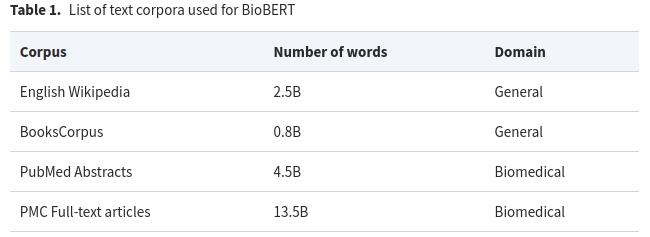

BioBERTa eredu handia da. Izan ere, ezkutuko dimentsioa H=768 da, 12 ezkutuko geruza L=12 eta 12 atentzio geruza A=12 ditu. Ikusi da PubMedBERTean batch_size=32 balioarekin lortu direla emaitza hobeak. Beraz, bakarrik probatuko da batch size horrekin.



In [ ]:
train_and_evaluate("dmis-lab/biobert-v1.1", "ner-biobert" , trainDataZ1, devDataZ1, max(tag_vocab.values()) + 1, embedding_size=768, doLowerCase=True, num_epochs=50)

Downloading:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/462 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/433M [00:00<?, ?B/s]

Some weights of BertForMaskedLM were not initialized from the model checkpoint at dmis-lab/biobert-v1.1 and are newly initialized: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 28/28 [00:03<00:00,  8.24it/s]


Avg dev loss: 0.363
Epoch 0, dev accuracy: 0.739,0.776,0.757


100%|██████████| 28/28 [00:03<00:00,  8.24it/s]


Avg dev loss: 0.323
Epoch 1, dev accuracy: 0.789,0.805,0.797


100%|██████████| 28/28 [00:03<00:00,  8.23it/s]


Avg dev loss: 0.313
Epoch 2, dev accuracy: 0.795,0.810,0.802


100%|██████████| 28/28 [00:03<00:00,  8.25it/s]


Avg dev loss: 0.308
Epoch 3, dev accuracy: 0.803,0.814,0.808


100%|██████████| 28/28 [00:03<00:00,  8.24it/s]


Avg dev loss: 0.306
Epoch 4, dev accuracy: 0.804,0.816,0.810


100%|██████████| 28/28 [00:03<00:00,  8.26it/s]


Avg dev loss: 0.307
Epoch 5, dev accuracy: 0.807,0.816,0.812


100%|██████████| 28/28 [00:03<00:00,  8.25it/s]


Avg dev loss: 0.309
Epoch 6, dev accuracy: 0.807,0.818,0.813


100%|██████████| 28/28 [00:03<00:00,  8.25it/s]


Avg dev loss: 0.317
Epoch 7, dev accuracy: 0.820,0.817,0.818


100%|██████████| 28/28 [00:03<00:00,  8.25it/s]


Avg dev loss: 0.318
Epoch 8, dev accuracy: 0.813,0.819,0.816


100%|██████████| 28/28 [00:03<00:00,  8.23it/s]


Avg dev loss: 0.312
Epoch 9, dev accuracy: 0.785,0.826,0.805


100%|██████████| 28/28 [00:03<00:00,  8.26it/s]


Avg dev loss: 0.317
Epoch 10, dev accuracy: 0.769,0.826,0.797


100%|██████████| 28/28 [00:03<00:00,  8.26it/s]


Avg dev loss: 0.323
Epoch 11, dev accuracy: 0.768,0.830,0.798


100%|██████████| 28/28 [00:03<00:00,  8.25it/s]


Avg dev loss: 0.330
Epoch 12, dev accuracy: 0.764,0.831,0.796


100%|██████████| 28/28 [00:03<00:00,  8.25it/s]


Avg dev loss: 0.337
Epoch 13, dev accuracy: 0.770,0.829,0.798


100%|██████████| 28/28 [00:03<00:00,  8.25it/s]


Avg dev loss: 0.345
Epoch 14, dev accuracy: 0.766,0.831,0.797


100%|██████████| 28/28 [00:03<00:00,  8.25it/s]


Avg dev loss: 0.350
Epoch 15, dev accuracy: 0.758,0.836,0.795


100%|██████████| 28/28 [00:03<00:00,  8.25it/s]


Avg dev loss: 0.354
Epoch 16, dev accuracy: 0.769,0.831,0.799


100%|██████████| 28/28 [00:03<00:00,  8.23it/s]


Avg dev loss: 0.369
Epoch 17, dev accuracy: 0.787,0.830,0.808


100%|██████████| 28/28 [00:03<00:00,  8.25it/s]


Avg dev loss: 0.384
Epoch 18, dev accuracy: 0.798,0.828,0.813


100%|██████████| 28/28 [00:03<00:00,  8.25it/s]


Avg dev loss: 0.407
Epoch 19, dev accuracy: 0.807,0.820,0.814


100%|██████████| 28/28 [00:03<00:00,  8.25it/s]


Avg dev loss: 0.413
Epoch 20, dev accuracy: 0.833,0.804,0.818


100%|██████████| 28/28 [00:03<00:00,  8.25it/s]


Avg dev loss: 0.419
Epoch 21, dev accuracy: 0.825,0.809,0.816


100%|██████████| 28/28 [00:03<00:00,  8.26it/s]


Avg dev loss: 0.407
Epoch 22, dev accuracy: 0.815,0.805,0.810


100%|██████████| 28/28 [00:03<00:00,  8.24it/s]


Avg dev loss: 0.413
Epoch 23, dev accuracy: 0.804,0.817,0.810


100%|██████████| 28/28 [00:03<00:00,  8.25it/s]


Avg dev loss: 0.428
Epoch 24, dev accuracy: 0.793,0.823,0.808


100%|██████████| 28/28 [00:03<00:00,  8.24it/s]


Avg dev loss: 0.444
Epoch 25, dev accuracy: 0.785,0.833,0.808


100%|██████████| 28/28 [00:03<00:00,  8.26it/s]


Avg dev loss: 0.445
Epoch 26, dev accuracy: 0.780,0.836,0.807


100%|██████████| 28/28 [00:03<00:00,  8.26it/s]


Avg dev loss: 0.447
Epoch 27, dev accuracy: 0.778,0.832,0.804


100%|██████████| 28/28 [00:03<00:00,  8.25it/s]


Avg dev loss: 0.444
Epoch 28, dev accuracy: 0.803,0.802,0.802


100%|██████████| 28/28 [00:03<00:00,  8.24it/s]


Avg dev loss: 0.459
Epoch 29, dev accuracy: 0.794,0.810,0.802


100%|██████████| 28/28 [00:03<00:00,  8.24it/s]


Avg dev loss: 0.473
Epoch 30, dev accuracy: 0.795,0.813,0.804


100%|██████████| 28/28 [00:03<00:00,  8.25it/s]


Avg dev loss: 0.483
Epoch 31, dev accuracy: 0.793,0.814,0.803


100%|██████████| 28/28 [00:03<00:00,  8.25it/s]


Avg dev loss: 0.489
Epoch 32, dev accuracy: 0.789,0.814,0.801


100%|██████████| 28/28 [00:03<00:00,  8.25it/s]


Avg dev loss: 0.488
Epoch 33, dev accuracy: 0.783,0.810,0.796


100%|██████████| 28/28 [00:03<00:00,  8.25it/s]


Avg dev loss: 0.495
Epoch 34, dev accuracy: 0.789,0.807,0.798


100%|██████████| 28/28 [00:03<00:00,  8.23it/s]


Avg dev loss: 0.498
Epoch 35, dev accuracy: 0.793,0.784,0.789


100%|██████████| 28/28 [00:03<00:00,  8.25it/s]


Avg dev loss: 0.489
Epoch 36, dev accuracy: 0.774,0.814,0.793


100%|██████████| 28/28 [00:03<00:00,  8.25it/s]


Avg dev loss: 0.506
Epoch 37, dev accuracy: 0.764,0.828,0.794


100%|██████████| 28/28 [00:03<00:00,  8.24it/s]


Avg dev loss: 0.524
Epoch 38, dev accuracy: 0.756,0.839,0.795


100%|██████████| 28/28 [00:03<00:00,  8.23it/s]


Avg dev loss: 0.539
Epoch 39, dev accuracy: 0.740,0.839,0.786


100%|██████████| 28/28 [00:03<00:00,  8.22it/s]


Avg dev loss: 0.540
Epoch 40, dev accuracy: 0.748,0.835,0.789


100%|██████████| 28/28 [00:03<00:00,  8.25it/s]


Avg dev loss: 0.543
Epoch 41, dev accuracy: 0.735,0.833,0.781


100%|██████████| 28/28 [00:03<00:00,  8.25it/s]


Avg dev loss: 0.552
Epoch 42, dev accuracy: 0.734,0.825,0.777


100%|██████████| 28/28 [00:03<00:00,  8.26it/s]


Avg dev loss: 0.547
Epoch 43, dev accuracy: 0.760,0.823,0.790


100%|██████████| 28/28 [00:03<00:00,  8.25it/s]


Avg dev loss: 0.552
Epoch 44, dev accuracy: 0.773,0.820,0.796


100%|██████████| 28/28 [00:03<00:00,  8.22it/s]


Avg dev loss: 0.566
Epoch 45, dev accuracy: 0.780,0.821,0.800


100%|██████████| 28/28 [00:03<00:00,  8.26it/s]


Avg dev loss: 0.585
Epoch 46, dev accuracy: 0.805,0.812,0.808


100%|██████████| 28/28 [00:03<00:00,  8.25it/s]


Avg dev loss: 0.590
Epoch 47, dev accuracy: 0.812,0.807,0.810


100%|██████████| 28/28 [00:03<00:00,  8.24it/s]


Avg dev loss: 0.615
Epoch 48, dev accuracy: 0.829,0.796,0.812


100%|██████████| 28/28 [00:03<00:00,  8.25it/s]


Avg dev loss: 0.620
Epoch 49, dev accuracy: 0.836,0.789,0.812

Best Performing Model achieves dev accuracy of :  0.836,0.789,0.812
Time: 2019.984 seconds ---


Azkenik, test-ean probatuko dugu gure modelo hoberena. Horretarako:  


1.   Aurre-entrenatutako modeloa hasieratuko dugu aurretik egin dugun moduan.
2.   Parametroak berridatziko ditugu gordetako modeloa erabiliz,
3. Gure modeloa ebaluatuko dugu test-eko datuak hartuz. Metrikak *precision*, *recall* eta *F1* dira hurrenez hurren.


In [ ]:
bert=BERTSequenceLabeler(params={"doLowerCase": True, "model_name": "dmis-lab/biobert-v1.1", "embedding_size":768, "label_length": max(tag_vocab.values())+1})
bert.to(device)
bert.load_state_dict(torch.load("ner-biobert"))

test_batch_x, test_batch_y = bert.get_batches(testDataZ1)
test_precision, test_recall, test_F1 = evaluateF1(bert, test_batch_x, test_batch_y)
print("\nBest Performing Model achieves test accuracy of :  %.3f,%.3f,%.3f" % (test_precision, test_recall, test_F1))

Downloading:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/462 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/433M [00:00<?, ?B/s]

Some weights of BertForMaskedLM were not initialized from the model checkpoint at dmis-lab/biobert-v1.1 and are newly initialized: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Best Performing Model achieves test accuracy of :  0.820,0.817,0.819


### Ondorioak


Hauek dira lortu diren emaitzak Z1 zereginean, BERT desberdinekin:  

| |BERT small | BiomedNLP-PubMedBERT | BioBERT |
|--|--|--|--|
Precision|0.848|0.823 (batch_size = 4) <br /> 0.811 (batch_size = 32) |0.820
Recall|0.766|0.796 (batch_size = 4) <br /> 0.826 (batch_size = 32) |0.817
F1|0.805|0.809 (batch_size = 4) <br /> **0.819** (batch_size = 32) |**0.819**

Ikus daitekenez, BERT espezializatuekin lortzen dira emaitza hobeak. Hau zen espero zena, BERT horiek gure corpuseko antzeko testuetan entrenatuak izan direlako. Beraz, hobe da atazera espezializatuak dauden BERTak erabiltzea.



## Z2 (1. bertsioa)
Klase bakarrekin lan egiteaz gain, Medmentions-eko klase semantiko ezberdinak bereiziko dira. Ez dira Medmentions-eko 128 klaseak iragarriko, detekzio finago egingo da. Zehazki, detektatuko dira gaixotasunekin erlazio duten taulako 23 klaseak. Horretarako BERT desberdinak doituko (fine-tunning) dira.  

|Klase mota|Klasearen IDa|
|--|--|
Health Care Activity | T058
Laboratory Procedure | T059
Diagnostic Procedure | T060
Therapeutic or Preventive Procedure | T061
Disease or Syndrome | T047
Mental or Behavioral Dysfunction | T048
Neoplastic Process | T191
Experimental Model of Disease | T050
Organism | T001
Virus | T005
Bacterium | T007
Anatomical Structure | T017
Embryonic Structure | T018
Fully Formed Anatomical Structure | T021
Body Part, Organ, or Organ Component | T023
Anatomical Abnormality | T190
Congenital Abnormality | T019
Acquired Abnormality | T020
Clinical Drug | T200
Pharmacologic Substance | T121
Antibiotic | T195
Finding | T033
Sign or Symptom | T184

Horretarako, lehenik hiztegi bat definituko dugu klasearen IDa eta klase mota daukagula bakoitzeko.

In [ ]:
#klaseak
klaseak = ["Health Care Activity", "Laboratory Procedure", "Diagnostic Procedure", "Therapeutic or Preventive Procedure", "Disease or Syndrome", "Mental or Behavioral Dysfunction", "Neoplastic Process", 
           "Experimental Model of Disease", "Organism", "Virus", " Bacterium" , "Anatomical Structure", "Embryonic Structure", "Fully Formed Anatomical Structure", "Body Part, Organ, or Organ Component",
           "Anatomical Abnormality", "Congenital Abnormality", "Acquired Abnormality", "Clinical Drug", "Pharmacologic Substance", "Antibiotic", "Finding", "Sign or Symptom"]

klaseak_ID = ["T058", "T059", "T060", "T061", "T047", "T048", "T191", "T050", "T001", "T005", "T007", "T017", "T018", "T021", "T023", "T190", "T019", "T020", "T200", "T121", "T195", "T033", "T184"]

etiketak = {}

assert(len(klaseak) == len(klaseak_ID))

for i in range(len(klaseak_ID)):
  etiketak[klaseak_ID[i]] = klaseak[i]

Konprobatu ondo sortuta dago datu-egitura:

In [ ]:
print(etiketak)

{'T058': 'Health Care Activity', 'T059': 'Laboratory Procedure', 'T060': 'Diagnostic Procedure', 'T061': 'Therapeutic or Preventive Procedure', 'T047': 'Disease or Syndrome', 'T048': 'Mental or Behavioral Dysfunction', 'T191': 'Neoplastic Process', 'T050': 'Experimental Model of Disease', 'T001': 'Organism', 'T005': 'Virus', 'T007': ' Bacterium', 'T017': 'Anatomical Structure', 'T018': 'Embryonic Structure', 'T021': 'Fully Formed Anatomical Structure', 'T023': 'Body Part, Organ, or Organ Component', 'T190': 'Anatomical Abnormality', 'T019': 'Congenital Abnormality', 'T020': 'Acquired Abnormality', 'T200': 'Clinical Drug', 'T121': 'Pharmacologic Substance', 'T195': 'Antibiotic', 'T033': 'Finding', 'T184': 'Sign or Symptom'}


### BIO etiketatzea
Orain datuak BIO etiketatzera pasatuko dira. Kasu honetan, Z1en ez bezala, etiketa anitz izango ditugu. Etiketa hauek aurretik definitu dira eta zehazki gaixotasunekin erlazio duten etiketak bakarrik dira. Beraz, tokena entitate baten hasiera baldin bada B-klasearenID etiketa jasoko du. I-klasearenID izango du aldiz, entitatearen barruan baldin badago eta 0 ez bada entitate bat edota entitate horren ID aurretik definitukoen artean ez badago. Jarraian adibide bat aurkezten da. Kasu horretan DCTN4 entitate bat da baina honen klaseen IDak T116, T123 dira eta hauek ez daudenez definitu ditugun etiketen artean, O etiketa hartzen du:

```
[DCTN4] as a modifier of [chronic Pseudomonas aeruginosa infection] in [cystic fibrosis]

O O O O O B-T047 I-T047 I-T047 I-T047 O B-T047 I-T047
```

Lehenik eta behin fitxategi berriak sortuko dira *train*, *dev* eta *test* partizio bakoitzeko kasuak BIO etiketatzean gordetzeko.

In [ ]:
#Aldagai orokorrak
train_BIO_directory_Z2 = "corpus_BIO_train_Z2.txt"
dev_BIO_directory_Z2 = "corpus_BIO_dev_Z2.txt"
test_BIO_directory_Z2 = "corpus_BIO_test_Z2.txt"

#sortu fitxategiak
createFile("./" + train_BIO_directory_Z2)
createFile("./" + dev_BIO_directory_Z2)
createFile("./" + test_BIO_directory_Z2)

Hurrengo funtzioak fitxategi bakoitza irakurri eta BIO moduan etiketatzen ditu klase anitz ditugula. 

In [ ]:
def readBIO_Z2_txt(filename, write_directory):
    
    """ Read input one by line """
    with open(filename) as file:
        lines = "" #it  will contain the tittle and abstract
        entitate_guztiak = []
        cont = 0
        cont_len = 0
        for line in file:
          if  "|" in line:
            if cont % 2 == 0 and cont != 0:
              #idatzi
              idatzi_entitateak(entitate_guztiak, write_directory)
              entitate_guztiak = []
              lines = ""           
              cont_len = 0   
            cont += 1
            text_ta = (line.split("|")[2]).split("\n")[0]
            tokenizatu_text_ta = tokenize(text_ta+ " ")
            for t in tokenizatu_text_ta:
              entitate_guztiak.append([t,cont_len , cont_len+len(t) ,"O"])
              cont_len += len(t)
            lines += text_ta + " "
          else:
            desk = line.split("\t")
            index_start = int(desk[1])
            index_end = int(desk[2])
            klase_id_ = str(desk[4]).split(",")
            klase_id = []
            #ikusiko dugu ea id-ren bat etiketen artean dagoen
            for id in klase_id_:
              if id  in etiketak.keys(): # badago
                klase_id.append(id)
            entitate = lines[index_start:index_end]
            entitate_tokenizatu = tokenize(entitate)
            first = True
            if len(klase_id) > 0:
              for ent in entitate_tokenizatu:
                if first:
                  if ent != " " :
                    try:
                      index = entitate_guztiak.index([ent,index_start, index_start + len(ent), "O"])
                      entitate_guztiak[index] = [ent,index_start, index_start + len(ent), "B-"+",".join(klase_id)]
                      index_start += len(ent)
                      first = False
                    except:
                      index += 1
                      entitate_guztiak.insert(index, [ent, len(entitate_guztiak[index-1][0]), len(entitate_guztiak[index-1][0])+len(ent), "B-"+",".join(klase_id)])
                      index_start += len(ent)
                      first = False
                  else:
                    index_start += 1
                elif ent != " ":
                  try:
                    index = entitate_guztiak.index([ent,index_start, index_start +len(ent), "O"])
                    entitate_guztiak[index] = [ent,index_start, index_start +len(ent), "I-"+",".join(klase_id)]
                    index_start += len(ent)
                  except:
                    index += 1
                    entitate_guztiak.insert(index, [ent, len(entitate_guztiak[index-1][0]), len(entitate_guztiak[index-1][0])+len(ent), "I-"+",".join(klase_id)])
                    index_start += len(ent)
                else:
                  index_start += 1
        #azkena
        idatzi_entitateak(entitate_guztiak, write_directory)

In [ ]:
readBIO_Z2_txt(dev_def_directory ,dev_BIO_directory_Z2)
readBIO_Z2_txt(test_def_directory ,test_BIO_directory_Z2)
readBIO_Z2_txt(train_def_directory ,train_BIO_directory_Z2)

### BIO moduan etiketatutako datuak irakurri

Aurretik definitutako ```read_txt()``` funtzioa erabiliko da aurretik etiketatu diren datuak irakurtzeko. Funtzio horrek datuak irakurri eta esaldiz osatutako lista bat sortzen du. Esaldi bakoitza tuplas osatutako lista bat da eta tupla bakoitzA bi elementuz osatuta dago: hitza eta etiketa (O,B,I).


In [ ]:
trainDataZ2 = read_txt(train_BIO_directory_Z2)
devDataZ2 = read_txt(dev_BIO_directory_Z2)
testDataZ2 = read_txt(test_BIO_directory_Z2)

Ikusiko da egitura egokia dela, hau da, aurretik aipatuta egitura duela:

In [ ]:
print(trainDataZ2[0])
print(len(trainDataZ2))
print(len(devDataZ2))
print(len(testDataZ2))

[('An', 'O'), ('S116R', 'O'), ('Phosphorylation', 'O'), ('Site', 'O'), ('Mutation', 'O'), ('in', 'O'), ('Human', 'O'), ('Fibroblast', 'O'), ('Growth', 'O'), ('Factor-1', 'O'), ('Differentially', 'O'), ('Affects', 'O'), ('Mitogenic', 'O'), ('and', 'O'), ('Glucose', 'B-T033'), ('-', 'I-T033'), ('Lowering', 'I-T033'), ('Activities', 'I-T033'), ('Fibroblast', 'O'), ('growth', 'O'), ('factor-1', 'O'), ('(', 'O'), ('FGF-1', 'O'), (')', 'O'), (',', 'O'), ('a', 'O'), ('potent', 'O'), ('human', 'O'), ('mitogen', 'O'), ('and', 'O'), ('insulin', 'B-T121'), ('sensitizer', 'O'), (',', 'O'), ('signals', 'O'), ('through', 'O'), ('both', 'O'), ('tyrosine', 'O'), ('kinase', 'O'), ('receptor', 'O'), ('-mediated', 'O'), ('autocrine', 'O'), ('/', 'O'), ('paracrine', 'O'), ('pathways', 'O'), ('as', 'O'), ('well', 'O'), ('as', 'O'), ('a', 'O'), ('nuclear', 'O'), ('intracrine', 'O'), ('pathway', 'O'), ('.', 'O'), ('Phosphorylation', 'O'), ('of', 'O'), ('FGF-1', 'O'), ('at', 'O'), ('serine', 'B-T121'), ('116'

Orain, entrenamendu-datuetan jaso ahal diren etiketa guztien indize bat eman zaie, hurrengo datu-egitura sortuz: hiztegi bat etiketekin eta indizearekin, eta alderantzizko hiztegia indezeekin eta etiketekin. Horretako aurretik definitutako get_tag_vocab()funtzioa erabiliko da. Gero, inprimatzen dira sortutako bi egitura berriak. 

In [ ]:
tag_vocab_train,rev_tags_train=get_tag_vocab(trainDataZ2)

print(tag_vocab_train)
print(rev_tags_train)
print(rev_tags_train[0])
tag_vocab = tag_vocab_train
rev_tags = rev_tags_train

{'O': 0, 'B-T033': 1, 'I-T033': 2, 'B-T121': 3, 'I-T121': 4, 'B-T047': 5, 'I-T047': 6, 'B-T061': 7, 'B-T059': 8, 'I-T059': 9, 'I-T061': 10, 'B-T058': 11, 'I-T058': 12, 'B-T184': 13, 'I-T184': 14, 'B-T060': 15, 'I-T060': 16, 'B-T005': 17, 'B-T007': 18, 'B-T001': 19, 'I-T007': 20, 'B-T191': 21, 'B-T023': 22, 'I-T023': 23, 'B-T019': 24, 'I-T019': 25, 'B-T050': 26, 'I-T050': 27, 'I-T001': 28, 'B-T048': 29, 'B-T020': 30, 'I-T191': 31, 'B-T190': 32, 'I-T190': 33, 'I-T048': 34, 'B-T195': 35, 'I-T005': 36, 'I-T195': 37, 'B-T017': 38, 'I-T020': 39, 'B-T200': 40, 'I-T200': 41, 'B-T018': 42, 'I-T017': 43, 'I-T018': 44, 'B-T019,T047': 45, 'I-T019,T047': 46, 'B-T047,T190': 47, 'I-T047,T190': 48, 'B-T021': 49}
{0: 'O', 1: 'B-T033', 2: 'I-T033', 3: 'B-T121', 4: 'I-T121', 5: 'B-T047', 6: 'I-T047', 7: 'B-T061', 8: 'B-T059', 9: 'I-T059', 10: 'I-T061', 11: 'B-T058', 12: 'I-T058', 13: 'B-T184', 14: 'I-T184', 15: 'B-T060', 16: 'I-T060', 17: 'B-T005', 18: 'B-T007', 19: 'B-T001', 20: 'I-T007', 21: 'B-T191', 

Ikus daiteke nola entitate batzuek bi klase dituzten. Honek arazo bat suposa dezake biko konbinazio asko baitaude eta askok ez baldin badaude *train*-en gure ereduaren asmatze-tasa txikia izango delako. Hortaz, ikusiko ditugu zenbat etiketa ez dauden *train*-en.

In [ ]:
tag_vocab_test,rev_tags_test=get_tag_vocab(testDataZ2)

print(tag_vocab_test)
print(rev_tags_test)
print(len(tag_vocab_test))

{'B-T047': 0, 'I-T047': 1, 'O': 2, 'B-T060': 3, 'I-T060': 4, 'B-T058': 5, 'B-T033': 6, 'I-T033': 7, 'B-T050': 8, 'I-T050': 9, 'B-T061': 10, 'B-T023': 11, 'B-T121': 12, 'I-T121': 13, 'I-T023': 14, 'I-T061': 15, 'I-T058': 16, 'B-T184': 17, 'I-T184': 18, 'B-T191': 19, 'I-T191': 20, 'B-T059': 21, 'I-T059': 22, 'B-T001': 23, 'I-T001': 24, 'B-T007': 25, 'I-T007': 26, 'B-T020': 27, 'B-T005': 28, 'I-T005': 29, 'B-T190': 30, 'I-T190': 31, 'B-T019': 32, 'B-T048': 33, 'I-T048': 34, 'B-T195': 35, 'I-T195': 36, 'B-T018': 37, 'I-T018': 38, 'I-T020': 39, 'I-T019': 40, 'B-T019,T047': 41, 'I-T019,T047': 42, 'B-T017': 43, 'I-T017': 44, 'B-T200': 45, 'I-T200': 46, 'B-T021': 47}
{0: 'B-T047', 1: 'I-T047', 2: 'O', 3: 'B-T060', 4: 'I-T060', 5: 'B-T058', 6: 'B-T033', 7: 'I-T033', 8: 'B-T050', 9: 'I-T050', 10: 'B-T061', 11: 'B-T023', 12: 'B-T121', 13: 'I-T121', 14: 'I-T023', 15: 'I-T061', 16: 'I-T058', 17: 'B-T184', 18: 'I-T184', 19: 'B-T191', 20: 'I-T191', 21: 'B-T059', 22: 'I-T059', 23: 'B-T001', 24: 'I-T00

In [ ]:
tag_vocab_dev,rev_tags_dev=get_tag_vocab(devDataZ2)

print(tag_vocab_dev)
print(rev_tags_dev)
print(len(tag_vocab_dev))

{'O': 0, 'B-T023': 1, 'B-T033': 2, 'B-T018': 3, 'B-T061': 4, 'B-T047': 5, 'I-T047': 6, 'I-T033': 7, 'I-T061': 8, 'B-T058': 9, 'B-T121': 10, 'I-T058': 11, 'I-T121': 12, 'B-T059': 13, 'B-T001': 14, 'B-T007': 15, 'I-T007': 16, 'I-T023': 17, 'B-T050': 18, 'I-T050': 19, 'B-T184': 20, 'B-T017': 21, 'B-T060': 22, 'I-T060': 23, 'B-T019,T047': 24, 'I-T019,T047': 25, 'B-T019': 26, 'I-T019': 27, 'I-T059': 28, 'B-T191': 29, 'I-T191': 30, 'B-T048': 31, 'I-T048': 32, 'I-T184': 33, 'B-T005': 34, 'B-T050,T191': 35, 'I-T050,T191': 36, 'I-T005': 37, 'B-T195': 38, 'I-T195': 39, 'B-T020': 40, 'I-T020': 41, 'B-T190': 42, 'I-T190': 43, 'I-T001': 44, 'I-T017': 45, 'I-T018': 46, 'B-T200': 47, 'I-T200': 48}
{0: 'O', 1: 'B-T023', 2: 'B-T033', 3: 'B-T018', 4: 'B-T061', 5: 'B-T047', 6: 'I-T047', 7: 'I-T033', 8: 'I-T061', 9: 'B-T058', 10: 'B-T121', 11: 'I-T058', 12: 'I-T121', 13: 'B-T059', 14: 'B-T001', 15: 'B-T007', 16: 'I-T007', 17: 'I-T023', 18: 'B-T050', 19: 'I-T050', 20: 'B-T184', 21: 'B-T017', 22: 'B-T060', 

In [ ]:
def konparatu(train, konparatzeko):
  ez_daudenak = []
  for key, value in konparatzeko.items():
    if key not in train.keys():
      ez_daudenak.append(key)
  return ez_daudenak

In [ ]:
print("Testeko ze etiketa ez dauden train-en:")
print(konparatu(tag_vocab_train, tag_vocab_test))
print("Deveko ze etiketa ez dauden train-en:")
print(konparatu(tag_vocab_train, tag_vocab_dev))

Testeko ze etiketa ez dauden train-en:
[]
Deveko ze etiketa ez dauden train-en:
['B-T050,T191', 'I-T050,T191']


Taula honetan laburbiltzen da dauden etiketa kopurua partizio bakoitzeko eta *train*en zenbat etiketa ez dauden:

||Train|Dev|Test|
|--|--|--|--|
Etiketa kopurua | 50|48|49
Train-en ez dauden etiketak|--|B-T050,T191', 'I-T050,T191'|$∅$|

Dev-eko bi etiketa baino ez daude trainen. Hori ona da 48 etiketetatik 2 baino ez daudelako trainen, beste 46ak badaude. Hortaz, ez da espero emaitza oso txarrak lortzea.


### BERT orokorra doitu

Datuak irakurrita, prozesatuta eta mini-batchak eta ebaluazio funtzioak daudela (hauek Z1en definitu dira). Aurre-entrenatutako BERT eredu orokor bat kargatuko da NER etiketatzea egiteko eta traineko datuekin doitu egingo da gure probleman hobeto egiten ikasteko. Gero dev-ekin hainbat aldiz konprobatuko da ondo egiten dela eta azkenik, test-ekin ebaluatuko da.

Tamaina desberdinetako BERT-ak daude, geruza kopuru desberdinekin (2, 4, 6, 8, 10) eta dimentsio desberdinekin (128, 256, 512). Zenbat eta txikiago izan azkarrago entrenatzen da baina lortzen diren emaitzak txarragoak dira. Beraz, erabaki da ez oso txikia eta ez oso handia den eredu bat erabiltzea. Modu honetan lortzen diren emaitzak nahiko onak izango dira denbora nahiko txikian. Zehazki, *bert-small* erabili da ezkutuko dimentsioa H=512 dena, 4 ezkutuko geruza L=4 eta 8 atentzio geruza A=8 dituena.

Jarraian modelo hori erabili da epoch bakoitzeko *precision*, *recall* eta *F1* lortzen direlarik. F1, aipatu bezala, bi metrikak erlazionatzen dituenez hau erabili hau *best_dev_acc* bezala. 

In [ ]:
train_and_evaluate("google/bert_uncased_L-4_H-512_A-8", "ner-bert-small-Z2" , trainDataZ2, devDataZ2, max(tag_vocab.values()) + 1, embedding_size=512, doLowerCase=True, num_epochs=50)

Some weights of the model checkpoint at google/bert_uncased_L-4_H-512_A-8 were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 28/28 [00:02<00:00, 12.96it/s]


Avg dev loss: 0.957
Epoch 0, dev accuracy: 0.000,0.000,0.000


100%|██████████| 28/28 [00:02<00:00, 12.86it/s]


Avg dev loss: 0.852
Epoch 1, dev accuracy: 0.000,0.000,0.000


100%|██████████| 28/28 [00:02<00:00, 12.24it/s]


Avg dev loss: 0.802
Epoch 2, dev accuracy: 0.222,0.013,0.024


100%|██████████| 28/28 [00:02<00:00, 12.27it/s]


Avg dev loss: 0.752
Epoch 3, dev accuracy: 0.274,0.054,0.091


100%|██████████| 28/28 [00:02<00:00, 12.52it/s]


Avg dev loss: 0.695
Epoch 4, dev accuracy: 0.283,0.095,0.142


100%|██████████| 28/28 [00:02<00:00, 12.35it/s]


Avg dev loss: 0.640
Epoch 5, dev accuracy: 0.367,0.156,0.219


100%|██████████| 28/28 [00:02<00:00, 12.26it/s]


Avg dev loss: 0.594
Epoch 6, dev accuracy: 0.424,0.215,0.285


100%|██████████| 28/28 [00:02<00:00, 12.32it/s]


Avg dev loss: 0.562
Epoch 7, dev accuracy: 0.439,0.259,0.326


100%|██████████| 28/28 [00:02<00:00, 12.38it/s]


Avg dev loss: 0.536
Epoch 8, dev accuracy: 0.481,0.286,0.359


100%|██████████| 28/28 [00:02<00:00, 12.35it/s]


Avg dev loss: 0.518
Epoch 9, dev accuracy: 0.505,0.313,0.386


100%|██████████| 28/28 [00:02<00:00, 12.49it/s]


Avg dev loss: 0.505
Epoch 10, dev accuracy: 0.518,0.334,0.406


100%|██████████| 28/28 [00:02<00:00, 12.25it/s]


Avg dev loss: 0.494
Epoch 11, dev accuracy: 0.537,0.353,0.426


100%|██████████| 28/28 [00:02<00:00, 12.38it/s]


Avg dev loss: 0.483
Epoch 12, dev accuracy: 0.568,0.367,0.446


100%|██████████| 28/28 [00:02<00:00, 12.37it/s]


Avg dev loss: 0.474
Epoch 13, dev accuracy: 0.590,0.373,0.457


100%|██████████| 28/28 [00:02<00:00, 12.38it/s]


Avg dev loss: 0.469
Epoch 14, dev accuracy: 0.578,0.396,0.470


100%|██████████| 28/28 [00:02<00:00, 12.32it/s]


Avg dev loss: 0.464
Epoch 15, dev accuracy: 0.584,0.411,0.483


100%|██████████| 28/28 [00:02<00:00, 12.34it/s]


Avg dev loss: 0.458
Epoch 16, dev accuracy: 0.596,0.413,0.488


100%|██████████| 28/28 [00:02<00:00, 12.40it/s]


Avg dev loss: 0.454
Epoch 17, dev accuracy: 0.596,0.422,0.494


100%|██████████| 28/28 [00:02<00:00, 12.38it/s]


Avg dev loss: 0.452
Epoch 18, dev accuracy: 0.587,0.432,0.498


100%|██████████| 28/28 [00:02<00:00, 12.34it/s]


Avg dev loss: 0.449
Epoch 19, dev accuracy: 0.590,0.438,0.503


100%|██████████| 28/28 [00:02<00:00, 12.37it/s]


Avg dev loss: 0.448
Epoch 20, dev accuracy: 0.590,0.445,0.507


100%|██████████| 28/28 [00:02<00:00, 12.39it/s]


Avg dev loss: 0.447
Epoch 21, dev accuracy: 0.590,0.456,0.515


100%|██████████| 28/28 [00:02<00:00, 12.29it/s]


Avg dev loss: 0.447
Epoch 22, dev accuracy: 0.589,0.464,0.519


100%|██████████| 28/28 [00:02<00:00, 12.32it/s]


Avg dev loss: 0.446
Epoch 23, dev accuracy: 0.596,0.464,0.522


100%|██████████| 28/28 [00:02<00:00, 12.39it/s]


Avg dev loss: 0.447
Epoch 24, dev accuracy: 0.579,0.480,0.524


100%|██████████| 28/28 [00:02<00:00, 12.36it/s]


Avg dev loss: 0.444
Epoch 25, dev accuracy: 0.598,0.470,0.526


100%|██████████| 28/28 [00:02<00:00, 12.32it/s]


Avg dev loss: 0.447
Epoch 26, dev accuracy: 0.591,0.484,0.532


100%|██████████| 28/28 [00:02<00:00, 12.35it/s]


Avg dev loss: 0.448
Epoch 27, dev accuracy: 0.581,0.494,0.534


100%|██████████| 28/28 [00:02<00:00, 12.25it/s]


Avg dev loss: 0.449
Epoch 28, dev accuracy: 0.576,0.495,0.532


100%|██████████| 28/28 [00:02<00:00, 12.40it/s]


Avg dev loss: 0.448
Epoch 29, dev accuracy: 0.592,0.494,0.539


100%|██████████| 28/28 [00:02<00:00, 12.41it/s]


Avg dev loss: 0.454
Epoch 30, dev accuracy: 0.573,0.509,0.539


100%|██████████| 28/28 [00:02<00:00, 12.35it/s]


Avg dev loss: 0.477
Epoch 31, dev accuracy: 0.533,0.541,0.537


100%|██████████| 28/28 [00:02<00:00, 12.28it/s]


Avg dev loss: 0.526
Epoch 32, dev accuracy: 0.493,0.571,0.529


100%|██████████| 28/28 [00:02<00:00, 12.36it/s]


Avg dev loss: 0.516
Epoch 33, dev accuracy: 0.498,0.569,0.531


100%|██████████| 28/28 [00:02<00:00, 12.37it/s]


Avg dev loss: 0.504
Epoch 34, dev accuracy: 0.507,0.564,0.534


100%|██████████| 28/28 [00:02<00:00, 12.44it/s]


Avg dev loss: 0.464
Epoch 35, dev accuracy: 0.560,0.536,0.548


100%|██████████| 28/28 [00:02<00:00, 12.36it/s]


Avg dev loss: 0.457
Epoch 36, dev accuracy: 0.580,0.520,0.548


100%|██████████| 28/28 [00:02<00:00, 12.30it/s]


Avg dev loss: 0.457
Epoch 37, dev accuracy: 0.588,0.508,0.545


100%|██████████| 28/28 [00:02<00:00, 12.35it/s]


Avg dev loss: 0.465
Epoch 38, dev accuracy: 0.569,0.521,0.544


100%|██████████| 28/28 [00:02<00:00, 12.33it/s]


Avg dev loss: 0.467
Epoch 39, dev accuracy: 0.572,0.522,0.545


100%|██████████| 28/28 [00:02<00:00, 12.37it/s]


Avg dev loss: 0.470
Epoch 40, dev accuracy: 0.566,0.526,0.545


100%|██████████| 28/28 [00:02<00:00, 12.34it/s]


Avg dev loss: 0.471
Epoch 41, dev accuracy: 0.568,0.526,0.546


100%|██████████| 28/28 [00:02<00:00, 12.28it/s]


Avg dev loss: 0.474
Epoch 42, dev accuracy: 0.570,0.525,0.547


100%|██████████| 28/28 [00:02<00:00, 12.28it/s]


Avg dev loss: 0.477
Epoch 43, dev accuracy: 0.570,0.527,0.548


100%|██████████| 28/28 [00:02<00:00, 12.42it/s]


Avg dev loss: 0.481
Epoch 44, dev accuracy: 0.562,0.535,0.548


100%|██████████| 28/28 [00:02<00:00, 12.28it/s]


Avg dev loss: 0.487
Epoch 45, dev accuracy: 0.552,0.536,0.544


100%|██████████| 28/28 [00:02<00:00, 12.34it/s]


Avg dev loss: 0.490
Epoch 46, dev accuracy: 0.552,0.536,0.544


100%|██████████| 28/28 [00:02<00:00, 12.32it/s]


Avg dev loss: 0.490
Epoch 47, dev accuracy: 0.561,0.531,0.545


100%|██████████| 28/28 [00:02<00:00, 12.28it/s]


Avg dev loss: 0.499
Epoch 48, dev accuracy: 0.543,0.552,0.547


100%|██████████| 28/28 [00:02<00:00, 12.33it/s]


Avg dev loss: 0.508
Epoch 49, dev accuracy: 0.539,0.555,0.547

Best Performing Model achieves dev accuracy of :  0.539,0.555,0.547
Time: 1385.637 seconds ---


Azkenik, test-ean probatuko dugu gure modelo hoberena. Horretarako:  


1.   Aurre-entrenatutako modeloa hasieratuko dugu aurretik egin dugun moduan.
2.   Parametroak berridatziko ditugu gordetako modeloa erabiliz,
3. Gure modeloa ebaluatuko dugu test-eko datuak hartuz. Metrikak *precision*, *recall* eta *F1* dira hurrenez hurren.


In [ ]:
bert=BERTSequenceLabeler(params={"doLowerCase": True, "model_name": "google/bert_uncased_L-4_H-512_A-8", "embedding_size":512, "label_length": max(tag_vocab.values())+1})
bert.to(device)
bert.load_state_dict(torch.load('ner-bert-small-Z2'))

test_batch_x, test_batch_y = bert.get_batches(testDataZ2)
test_precision, test_recall, test_F1 = evaluateF1(bert, test_batch_x, test_batch_y)
print("\nBest Performing Model achieves test accuracy of :  %.3f,%.3f,%.3f" % (test_precision, test_recall, test_F1))


Some weights of the model checkpoint at google/bert_uncased_L-4_H-512_A-8 were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



Best Performing Model achieves test accuracy of :  0.578,0.518,0.546


### BERT espezializatuak doitu
BERT orokorrarekin lortu diren emaitzak hurrengoak dira: 0.578,0.518,0.546 (precision, recall eta F1). Emaitza nahiko onak dira nahiz era honek *biomedical* terminoen gainean ez entrenatuta egon. Hortaz, BERT espezializatuak probatuko dira asmatze-tasa handitzeko asmoarekin.  BERT hauek *biomedical* terminoen gainean aurre-entrenatuak egongo dira. Konkretuki bi BERT probatuko dira: BiomedNLP-PubMedBERT eta BioBERT.

Aurre-entrenatutako bi BERT horiek kargatuko dira NER etiketatzea egiteko eta traineko datuekin doitu egingo dira gure probleman hobeto egiten ikasteko. Gero dev-ekin hainbat aldiz konprobatuko da ondo egiten dutela eta azkenik, test-ekin ebaluatuko dira.


#### **BiomedNLP-PubMedBERT**
PubMedBERT aurre entrenatuta dago PubMed abstrakten eta PubMedCentral artikuluen gainean. Jakinda gure *corpus*ak PubMed abstract-ak dituela, honek asmatze-tasa handitzea oso posiblea da.

PubMedBERTa eredu handia da. Izan ere, ezkutuko dimentsioa H=768 da, 12 ezkutuko geruza L=12 eta 12 atentzio geruza A=12 ditu. Ikusi da Z1n batch_size=32 balioarekin lortu direla emaitza hobeak. Beraz, bakarrik probatuko da batch size horrekin.

In [ ]:
train_and_evaluate("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext", "ner-pubZ2" , trainDataZ2, devDataZ2, max(tag_vocab.values()) + 1, embedding_size=768, doLowerCase=True, num_epochs=50)

Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 28/28 [00:03<00:00,  8.17it/s]


Avg dev loss: 0.835
Epoch 0, dev accuracy: 0.000,0.000,0.000


100%|██████████| 28/28 [00:03<00:00,  8.18it/s]


Avg dev loss: 0.681
Epoch 1, dev accuracy: 0.033,0.000,0.001


100%|██████████| 28/28 [00:03<00:00,  8.17it/s]


Avg dev loss: 0.571
Epoch 2, dev accuracy: 0.208,0.128,0.159


100%|██████████| 28/28 [00:03<00:00,  8.17it/s]


Avg dev loss: 0.475
Epoch 3, dev accuracy: 0.249,0.199,0.222


100%|██████████| 28/28 [00:03<00:00,  8.18it/s]


Avg dev loss: 0.428
Epoch 4, dev accuracy: 0.311,0.268,0.288


100%|██████████| 28/28 [00:03<00:00,  8.17it/s]


Avg dev loss: 0.400
Epoch 5, dev accuracy: 0.393,0.327,0.357


100%|██████████| 28/28 [00:03<00:00,  8.18it/s]


Avg dev loss: 0.375
Epoch 6, dev accuracy: 0.499,0.395,0.441


100%|██████████| 28/28 [00:03<00:00,  8.16it/s]


Avg dev loss: 0.354
Epoch 7, dev accuracy: 0.602,0.453,0.517


100%|██████████| 28/28 [00:03<00:00,  8.18it/s]


Avg dev loss: 0.343
Epoch 8, dev accuracy: 0.639,0.497,0.559


100%|██████████| 28/28 [00:03<00:00,  8.18it/s]


Avg dev loss: 0.334
Epoch 9, dev accuracy: 0.655,0.510,0.573


100%|██████████| 28/28 [00:03<00:00,  8.15it/s]


Avg dev loss: 0.331
Epoch 10, dev accuracy: 0.651,0.526,0.582


100%|██████████| 28/28 [00:03<00:00,  8.18it/s]


Avg dev loss: 0.327
Epoch 11, dev accuracy: 0.640,0.542,0.587


100%|██████████| 28/28 [00:03<00:00,  8.18it/s]


Avg dev loss: 0.324
Epoch 12, dev accuracy: 0.668,0.535,0.594


100%|██████████| 28/28 [00:03<00:00,  8.15it/s]


Avg dev loss: 0.321
Epoch 13, dev accuracy: 0.658,0.549,0.598


100%|██████████| 28/28 [00:03<00:00,  8.17it/s]


Avg dev loss: 0.321
Epoch 14, dev accuracy: 0.695,0.528,0.600


100%|██████████| 28/28 [00:03<00:00,  8.18it/s]


Avg dev loss: 0.324
Epoch 15, dev accuracy: 0.669,0.558,0.608


100%|██████████| 28/28 [00:03<00:00,  8.18it/s]


Avg dev loss: 0.329
Epoch 16, dev accuracy: 0.646,0.576,0.609


100%|██████████| 28/28 [00:03<00:00,  8.18it/s]


Avg dev loss: 0.334
Epoch 17, dev accuracy: 0.632,0.596,0.613


100%|██████████| 28/28 [00:03<00:00,  8.18it/s]


Avg dev loss: 0.338
Epoch 18, dev accuracy: 0.643,0.588,0.614


100%|██████████| 28/28 [00:03<00:00,  8.18it/s]


Avg dev loss: 0.346
Epoch 19, dev accuracy: 0.646,0.578,0.610


100%|██████████| 28/28 [00:03<00:00,  8.18it/s]


Avg dev loss: 0.350
Epoch 20, dev accuracy: 0.629,0.600,0.614


100%|██████████| 28/28 [00:03<00:00,  8.18it/s]


Avg dev loss: 0.344
Epoch 21, dev accuracy: 0.661,0.582,0.619


100%|██████████| 28/28 [00:03<00:00,  8.18it/s]


Avg dev loss: 0.343
Epoch 22, dev accuracy: 0.668,0.574,0.618


100%|██████████| 28/28 [00:03<00:00,  8.17it/s]


Avg dev loss: 0.376
Epoch 23, dev accuracy: 0.576,0.643,0.607


100%|██████████| 28/28 [00:03<00:00,  8.19it/s]


Avg dev loss: 0.379
Epoch 24, dev accuracy: 0.571,0.649,0.608


100%|██████████| 28/28 [00:03<00:00,  8.15it/s]


Avg dev loss: 0.369
Epoch 25, dev accuracy: 0.585,0.638,0.611


100%|██████████| 28/28 [00:03<00:00,  8.18it/s]


Avg dev loss: 0.377
Epoch 26, dev accuracy: 0.589,0.638,0.612


100%|██████████| 28/28 [00:03<00:00,  8.19it/s]


Avg dev loss: 0.373
Epoch 27, dev accuracy: 0.590,0.637,0.612


100%|██████████| 28/28 [00:03<00:00,  8.17it/s]


Avg dev loss: 0.387
Epoch 28, dev accuracy: 0.596,0.638,0.616


100%|██████████| 28/28 [00:03<00:00,  8.18it/s]


Avg dev loss: 0.382
Epoch 29, dev accuracy: 0.598,0.635,0.616


100%|██████████| 28/28 [00:03<00:00,  8.17it/s]


Avg dev loss: 0.394
Epoch 30, dev accuracy: 0.598,0.637,0.617


100%|██████████| 28/28 [00:03<00:00,  8.17it/s]


Avg dev loss: 0.387
Epoch 31, dev accuracy: 0.612,0.633,0.622


100%|██████████| 28/28 [00:03<00:00,  8.17it/s]


Avg dev loss: 0.399
Epoch 32, dev accuracy: 0.603,0.641,0.621


100%|██████████| 28/28 [00:03<00:00,  8.18it/s]


Avg dev loss: 0.399
Epoch 33, dev accuracy: 0.601,0.644,0.622


100%|██████████| 28/28 [00:03<00:00,  8.18it/s]


Avg dev loss: 0.408
Epoch 34, dev accuracy: 0.589,0.643,0.615


100%|██████████| 28/28 [00:03<00:00,  8.16it/s]


Avg dev loss: 0.408
Epoch 35, dev accuracy: 0.602,0.634,0.618


100%|██████████| 28/28 [00:03<00:00,  8.18it/s]


Avg dev loss: 0.411
Epoch 36, dev accuracy: 0.577,0.648,0.611


100%|██████████| 28/28 [00:03<00:00,  8.18it/s]


Avg dev loss: 0.407
Epoch 37, dev accuracy: 0.597,0.625,0.611


100%|██████████| 28/28 [00:03<00:00,  8.15it/s]


Avg dev loss: 0.405
Epoch 38, dev accuracy: 0.622,0.610,0.616


100%|██████████| 28/28 [00:03<00:00,  8.17it/s]


Avg dev loss: 0.401
Epoch 39, dev accuracy: 0.654,0.591,0.621


100%|██████████| 28/28 [00:03<00:00,  8.17it/s]


Avg dev loss: 0.407
Epoch 40, dev accuracy: 0.694,0.544,0.610


100%|██████████| 28/28 [00:03<00:00,  8.17it/s]


Avg dev loss: 0.406
Epoch 41, dev accuracy: 0.650,0.601,0.624


100%|██████████| 28/28 [00:03<00:00,  8.18it/s]


Avg dev loss: 0.411
Epoch 42, dev accuracy: 0.630,0.626,0.628


100%|██████████| 28/28 [00:03<00:00,  8.18it/s]


Avg dev loss: 0.420
Epoch 43, dev accuracy: 0.645,0.615,0.630


100%|██████████| 28/28 [00:03<00:00,  8.14it/s]


Avg dev loss: 0.426
Epoch 44, dev accuracy: 0.650,0.606,0.628


100%|██████████| 28/28 [00:03<00:00,  8.18it/s]


Avg dev loss: 0.434
Epoch 45, dev accuracy: 0.637,0.615,0.626


100%|██████████| 28/28 [00:03<00:00,  8.18it/s]


Avg dev loss: 0.436
Epoch 46, dev accuracy: 0.634,0.621,0.627


100%|██████████| 28/28 [00:03<00:00,  8.15it/s]


Avg dev loss: 0.441
Epoch 47, dev accuracy: 0.632,0.621,0.626


100%|██████████| 28/28 [00:03<00:00,  8.16it/s]


Avg dev loss: 0.448
Epoch 48, dev accuracy: 0.642,0.616,0.629


100%|██████████| 28/28 [00:03<00:00,  8.17it/s]


Avg dev loss: 0.451
Epoch 49, dev accuracy: 0.637,0.620,0.629

Best Performing Model achieves dev accuracy of :  0.637,0.620,0.629
Time: 2073.034 seconds ---


Azkenik, test-ean probatuko dugu gure modelo hoberena. Horretarako:  


1.   Aurre-entrenatutako modeloa hasieratuko dugu aurretik egin dugun moduan.
2.   Parametroak berridatziko ditugu gordetako modeloa erabiliz,
3. Gure modeloa ebaluatuko dugu test-eko datuak hartuz. Metrikak *precision*, *recall* eta *F1* dira hurrenez hurren.


In [ ]:
bert=BERTSequenceLabeler(params={"doLowerCase": True, "model_name": "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext", "embedding_size":768, "label_length": max(tag_vocab.values())+1})
bert.to(device)
bert.load_state_dict(torch.load("ner-pubZ2"))

test_batch_x, test_batch_y = bert.get_batches(testDataZ2)
test_precision, test_recall, test_F1 = evaluateF1(bert, test_batch_x, test_batch_y)
print("\nBest Performing Model achieves test accuracy of :  %.3f,%.3f,%.3f" % (test_precision, test_recall, test_F1))



Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



Best Performing Model achieves test accuracy of :  0.649,0.599,0.623


#### **BioBERT**
BioBERT aurre-entrenatuta BERT-en corpuseaz gain PubMED abstract eta PMC artikuluen gainean. Jakinda corpusak PubMed abstractak dituela asmatze-tasa igo dezake. 

BioBERTa eredu handia da. Izan ere, ezkutuko dimentsioa H=768 da, 12 ezkutuko geruza L=12 eta 12 atentzio geruza A=12 ditu. Bakarrik probatuko da batch size = 32 balioarekin.


In [ ]:
train_and_evaluate("dmis-lab/biobert-v1.1", "ner-biobertZ2" , trainDataZ2, devDataZ2, max(tag_vocab.values()) + 1, embedding_size=768, doLowerCase=True, num_epochs=50)

Some weights of BertForMaskedLM were not initialized from the model checkpoint at dmis-lab/biobert-v1.1 and are newly initialized: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 28/28 [00:03<00:00,  8.22it/s]


Avg dev loss: 0.902
Epoch 0, dev accuracy: 0.000,0.000,0.000


100%|██████████| 28/28 [00:03<00:00,  8.23it/s]


Avg dev loss: 0.700
Epoch 1, dev accuracy: 0.221,0.135,0.167


100%|██████████| 28/28 [00:03<00:00,  8.23it/s]


Avg dev loss: 0.566
Epoch 2, dev accuracy: 0.253,0.231,0.242


100%|██████████| 28/28 [00:03<00:00,  8.21it/s]


Avg dev loss: 0.512
Epoch 3, dev accuracy: 0.331,0.282,0.304


100%|██████████| 28/28 [00:03<00:00,  8.24it/s]


Avg dev loss: 0.477
Epoch 4, dev accuracy: 0.408,0.346,0.375


100%|██████████| 28/28 [00:03<00:00,  8.24it/s]


Avg dev loss: 0.449
Epoch 5, dev accuracy: 0.519,0.410,0.458


100%|██████████| 28/28 [00:03<00:00,  8.24it/s]


Avg dev loss: 0.428
Epoch 6, dev accuracy: 0.599,0.458,0.519


100%|██████████| 28/28 [00:03<00:00,  8.24it/s]


Avg dev loss: 0.413
Epoch 7, dev accuracy: 0.644,0.493,0.559


100%|██████████| 28/28 [00:03<00:00,  8.24it/s]


Avg dev loss: 0.408
Epoch 8, dev accuracy: 0.648,0.523,0.579


100%|██████████| 28/28 [00:03<00:00,  8.23it/s]


Avg dev loss: 0.405
Epoch 9, dev accuracy: 0.667,0.535,0.594


100%|██████████| 28/28 [00:03<00:00,  8.24it/s]


Avg dev loss: 0.400
Epoch 10, dev accuracy: 0.684,0.541,0.604


100%|██████████| 28/28 [00:03<00:00,  8.24it/s]


Avg dev loss: 0.401
Epoch 11, dev accuracy: 0.681,0.542,0.604


100%|██████████| 28/28 [00:03<00:00,  8.24it/s]


Avg dev loss: 0.405
Epoch 12, dev accuracy: 0.684,0.536,0.601


100%|██████████| 28/28 [00:03<00:00,  8.24it/s]


Avg dev loss: 0.403
Epoch 13, dev accuracy: 0.677,0.552,0.608


100%|██████████| 28/28 [00:03<00:00,  8.25it/s]


Avg dev loss: 0.439
Epoch 14, dev accuracy: 0.578,0.611,0.594


100%|██████████| 28/28 [00:03<00:00,  8.24it/s]


Avg dev loss: 0.435
Epoch 15, dev accuracy: 0.592,0.610,0.601


100%|██████████| 28/28 [00:03<00:00,  8.24it/s]


Avg dev loss: 0.437
Epoch 16, dev accuracy: 0.587,0.615,0.601


100%|██████████| 28/28 [00:03<00:00,  8.23it/s]


Avg dev loss: 0.433
Epoch 17, dev accuracy: 0.595,0.605,0.600


100%|██████████| 28/28 [00:03<00:00,  8.22it/s]


Avg dev loss: 0.430
Epoch 18, dev accuracy: 0.638,0.583,0.609


100%|██████████| 28/28 [00:03<00:00,  8.23it/s]


Avg dev loss: 0.443
Epoch 19, dev accuracy: 0.612,0.598,0.605


100%|██████████| 28/28 [00:03<00:00,  8.25it/s]


Avg dev loss: 0.444
Epoch 20, dev accuracy: 0.617,0.591,0.604


100%|██████████| 28/28 [00:03<00:00,  8.25it/s]


Avg dev loss: 0.454
Epoch 21, dev accuracy: 0.629,0.591,0.610


100%|██████████| 28/28 [00:03<00:00,  8.24it/s]


Avg dev loss: 0.451
Epoch 22, dev accuracy: 0.644,0.575,0.608


100%|██████████| 28/28 [00:03<00:00,  8.25it/s]


Avg dev loss: 0.460
Epoch 23, dev accuracy: 0.654,0.568,0.608


100%|██████████| 28/28 [00:03<00:00,  8.25it/s]


Avg dev loss: 0.472
Epoch 24, dev accuracy: 0.665,0.548,0.601


100%|██████████| 28/28 [00:03<00:00,  8.25it/s]


Avg dev loss: 0.466
Epoch 25, dev accuracy: 0.654,0.560,0.603


100%|██████████| 28/28 [00:03<00:00,  8.24it/s]


Avg dev loss: 0.464
Epoch 26, dev accuracy: 0.645,0.577,0.609


100%|██████████| 28/28 [00:03<00:00,  8.25it/s]


Avg dev loss: 0.488
Epoch 27, dev accuracy: 0.601,0.605,0.603


100%|██████████| 28/28 [00:03<00:00,  8.25it/s]


Avg dev loss: 0.500
Epoch 28, dev accuracy: 0.602,0.611,0.607


100%|██████████| 28/28 [00:03<00:00,  8.24it/s]


Avg dev loss: 0.499
Epoch 29, dev accuracy: 0.618,0.601,0.609


100%|██████████| 28/28 [00:03<00:00,  8.24it/s]


Avg dev loss: 0.506
Epoch 30, dev accuracy: 0.608,0.601,0.605


100%|██████████| 28/28 [00:03<00:00,  8.25it/s]


Avg dev loss: 0.514
Epoch 31, dev accuracy: 0.620,0.598,0.609


100%|██████████| 28/28 [00:03<00:00,  8.22it/s]


Avg dev loss: 0.526
Epoch 32, dev accuracy: 0.622,0.596,0.609


100%|██████████| 28/28 [00:03<00:00,  8.25it/s]


Avg dev loss: 0.545
Epoch 33, dev accuracy: 0.622,0.598,0.610


100%|██████████| 28/28 [00:03<00:00,  8.25it/s]


Avg dev loss: 0.535
Epoch 34, dev accuracy: 0.635,0.588,0.610


100%|██████████| 28/28 [00:03<00:00,  8.24it/s]


Avg dev loss: 0.550
Epoch 35, dev accuracy: 0.630,0.592,0.610


100%|██████████| 28/28 [00:03<00:00,  8.25it/s]


Avg dev loss: 0.561
Epoch 36, dev accuracy: 0.607,0.604,0.605


100%|██████████| 28/28 [00:03<00:00,  8.24it/s]


Avg dev loss: 0.565
Epoch 37, dev accuracy: 0.620,0.592,0.606


100%|██████████| 28/28 [00:03<00:00,  8.25it/s]


Avg dev loss: 0.568
Epoch 38, dev accuracy: 0.617,0.595,0.606


100%|██████████| 28/28 [00:03<00:00,  8.23it/s]


Avg dev loss: 0.574
Epoch 39, dev accuracy: 0.640,0.587,0.613


100%|██████████| 28/28 [00:03<00:00,  8.24it/s]


Avg dev loss: 0.589
Epoch 40, dev accuracy: 0.632,0.594,0.612


100%|██████████| 28/28 [00:03<00:00,  8.23it/s]


Avg dev loss: 0.587
Epoch 41, dev accuracy: 0.619,0.600,0.610


100%|██████████| 28/28 [00:03<00:00,  8.25it/s]


Avg dev loss: 0.601
Epoch 42, dev accuracy: 0.615,0.610,0.613


100%|██████████| 28/28 [00:03<00:00,  8.24it/s]


Avg dev loss: 0.600
Epoch 43, dev accuracy: 0.617,0.600,0.608


100%|██████████| 28/28 [00:03<00:00,  8.25it/s]


Avg dev loss: 0.623
Epoch 44, dev accuracy: 0.600,0.618,0.609


100%|██████████| 28/28 [00:03<00:00,  8.25it/s]


Avg dev loss: 0.615
Epoch 45, dev accuracy: 0.594,0.624,0.609


100%|██████████| 28/28 [00:03<00:00,  8.24it/s]


Avg dev loss: 0.642
Epoch 46, dev accuracy: 0.587,0.626,0.606


100%|██████████| 28/28 [00:03<00:00,  8.25it/s]


Avg dev loss: 0.654
Epoch 47, dev accuracy: 0.581,0.633,0.606


100%|██████████| 28/28 [00:03<00:00,  8.22it/s]


Avg dev loss: 0.651
Epoch 48, dev accuracy: 0.593,0.621,0.607


100%|██████████| 28/28 [00:03<00:00,  8.24it/s]


Avg dev loss: 0.640
Epoch 49, dev accuracy: 0.601,0.619,0.610

Best Performing Model achieves dev accuracy of :  0.601,0.619,0.610
Time: 2024.891 seconds ---


Azkenik, test-ean probatuko dugu gure modelo hoberena. Horretarako:  


1.   Aurre-entrenatutako modeloa hasieratuko dugu aurretik egin dugun moduan.
2.   Parametroak berridatziko ditugu gordetako modeloa erabiliz,
3. Gure modeloa ebaluatuko dugu test-eko datuak hartuz. Metrikak *precision*, *recall* eta *F1* dira hurrenez hurren.


In [ ]:
bert=BERTSequenceLabeler(params={"doLowerCase": True, "model_name": "dmis-lab/biobert-v1.1", "embedding_size":768, "label_length": max(tag_vocab.values())+1})
bert.to(device)
bert.load_state_dict(torch.load("ner-biobertZ2"))

test_batch_x, test_batch_y = bert.get_batches(testDataZ2)
test_precision, test_recall, test_F1 = evaluateF1(bert, test_batch_x, test_batch_y)
print("\nBest Performing Model achieves test accuracy of :  %.3f,%.3f,%.3f" % (test_precision, test_recall, test_F1))


Some weights of BertForMaskedLM were not initialized from the model checkpoint at dmis-lab/biobert-v1.1 and are newly initialized: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Best Performing Model achieves test accuracy of :  0.627,0.608,0.618


### Ondorioak


Hauek dira lortu diren emaitzak Z2 zereginean, BERT desberdinekin:  

| |BERT small | BiomedNLP-PubMedBERT | BioBERT |
|--|--|--|--|
Precision|0.578|0.649 |0.627
Recall|0.518|0.599  |0.608
F1|0.546|**0.623** |0.618

Ikus daitekenez, BERT espezializatuekin, Z1n bezala, lortzen dira emaitza hobeak. Baina emaitza hauek Z1rekin konparatuz, baxuagoak dira. Hau gertatzen da entitate desberdinak iragarri behar dituelako eta hori ataza zailagoa da (Z1n bakarrik etiketa bat iragarri behar da). Gainera badaude entitate batzuk bi klase dituztela eta hau zailtasun gehiago gehitzen dio atazari biko konbinazio asko baitaude.

## Z2 (2.bertsioa)
Egin den ataza nahiko zaila da, bi klase aldi berean iragartzea ataza zaila delako. Hortaz, asmatze-tasa handitzeko asmoarekin bi etiketa daudenean bakarra hartuko da. Hori egiteko, bi aukera desberdin pentsatu dira:
1. Hartu lehenengo klsea. Adib: B-T050,T191 → B-T050
2. Hartu klase orokorrean. Adib:B-T047,T190 → B-T190 (T047: 6. klaseko eta T190:  4. klaseko da).

Erabaki da 1. aukera egitea errazagoa baita.



###BIO etiketatzea
Datuak BIO etiketatzera pasatuko dira berriz. Baina kasu honetan, entitate bakoitza klase bakarra izango du.


Lehenik eta behin fitxategi berriak sortuko dira *train*, *dev* eta *test* partizio bakoitzeko kasuak BIO etiketatzean gordetzeko.

In [ ]:
#Aldagai orokorrak
train_BIO_directory_Z2_2 = "corpus_BIO_train_Z2_2.txt"
dev_BIO_directory_Z2_2 = "corpus_BIO_dev_Z2_2.txt"
test_BIO_directory_Z2_2 = "./data/corpus_BIO_test_Z2_2.txt"

#sortu fitxategiak
#createFile("./" + train_BIO_directory_Z2_2)
#createFile("./" + dev_BIO_directory_Z2_2)
#createFile("./" + test_BIO_directory_Z2_2)

Hurrengo funtzioak fitxategi bakoitza irakurri eta BIO moduan etiketatzen ditu klase anitz ditugula. 

In [ ]:
def readBIO_Z2_2_txt(filename, write_directory):
    
    """ Read input one by line """
    with open(filename) as file:
        lines = "" #it  will contain the tittle and abstract
        entitate_guztiak = []
        cont = 0
        cont_len = 0
        for line in file:
          if  "|" in line:
            if cont % 2 == 0 and cont != 0:
              #idatzi
              idatzi_entitateak(entitate_guztiak, write_directory)
              entitate_guztiak = []
              lines = ""           
              cont_len = 0   
            cont += 1
            text_ta = (line.split("|")[2]).split("\n")[0]
            tokenizatu_text_ta = tokenize(text_ta+ " ")
            for t in tokenizatu_text_ta:
              entitate_guztiak.append([t,cont_len , cont_len+len(t) ,"O"])
              cont_len += len(t)
            lines += text_ta + " "
          else:
            desk = line.split("\t")
            index_start = int(desk[1])
            index_end = int(desk[2])
            klase_id_ = str(desk[4]).split(",")
            klase_id = []
            #ikusiko dugu ea id-ren bat etiketen artean dagoen
            for id in klase_id_:
              if id  in etiketak.keys(): # badago
                klase_id.append(id)
            entitate = lines[index_start:index_end]
            entitate_tokenizatu = tokenize(entitate)
            first = True
            
            if len(klase_id) > 0:
              klase_id = klase_id[0] #hainbat etiketa baditu bakarrik LEHENENGOA hartu
              for ent in entitate_tokenizatu:
                if first:
                  if ent != " " :
                    try:
                      index = entitate_guztiak.index([ent,index_start, index_start + len(ent), "O"])
                      entitate_guztiak[index] = [ent,index_start, index_start + len(ent), "B-"+klase_id]
                      index_start += len(ent)
                      first = False
                    except:
                      index += 1
                      entitate_guztiak.insert(index, [ent, len(entitate_guztiak[index-1][0]), len(entitate_guztiak[index-1][0])+len(ent), "B-"+klase_id])
                      index_start += len(ent)
                      first = False
                  else:
                    index_start += 1
                elif ent != " ":
                  try:
                    index = entitate_guztiak.index([ent,index_start, index_start +len(ent), "O"])
                    entitate_guztiak[index] = [ent,index_start, index_start +len(ent), "I-"+klase_id]
                    index_start += len(ent)
                  except:
                    index += 1
                    entitate_guztiak.insert(index, [ent, len(entitate_guztiak[index-1][0]), len(entitate_guztiak[index-1][0])+len(ent), "I-"+klase_id])
                    index_start += len(ent)
                else:
                  index_start += 1
        #azkena
        idatzi_entitateak(entitate_guztiak, write_directory)

In [ ]:
readBIO_Z2_2_txt(dev_def_directory ,dev_BIO_directory_Z2_2)
readBIO_Z2_2_txt(test_def_directory ,test_BIO_directory_Z2_2)
readBIO_Z2_2_txt(train_def_directory ,train_BIO_directory_Z2_2)

### BIO moduan etiketatutako datuak irakurri

Aurretik definitutako ```read_txt()``` funtzioa erabiliko da aurretik etiketatu diren datuak irakurtzeko. Funtzio horrek datuak irakurri eta esaldiz osatutako lista bat sortzen du. Esaldi bakoitza tuplas osatutako lista bat da eta tupla bakoitzA bi elementuz osatuta dago: hitza eta etiketa (O,B,I).


In [ ]:
trainDataZ2_2 = read_txt(train_BIO_directory_Z2_2)
devDataZ2_2 = read_txt(dev_BIO_directory_Z2_2)
testDataZ2_2 = read_txt(test_BIO_directory_Z2_2)

Ikusiko da egitura egokia dela, hau da, aurretik aipatuta egitura duela:

In [ ]:
print(trainDataZ2_2[0])
print(len(trainDataZ2_2))
print(len(devDataZ2_2))
print(len(testDataZ2_2))

[('An', 'O'), ('S116R', 'O'), ('Phosphorylation', 'O'), ('Site', 'O'), ('Mutation', 'O'), ('in', 'O'), ('Human', 'O'), ('Fibroblast', 'O'), ('Growth', 'O'), ('Factor-1', 'O'), ('Differentially', 'O'), ('Affects', 'O'), ('Mitogenic', 'O'), ('and', 'O'), ('Glucose', 'B-T033'), ('-', 'I-T033'), ('Lowering', 'I-T033'), ('Activities', 'I-T033'), ('Fibroblast', 'O'), ('growth', 'O'), ('factor-1', 'O'), ('(', 'O'), ('FGF-1', 'O'), (')', 'O'), (',', 'O'), ('a', 'O'), ('potent', 'O'), ('human', 'O'), ('mitogen', 'O'), ('and', 'O'), ('insulin', 'B-T121'), ('sensitizer', 'O'), (',', 'O'), ('signals', 'O'), ('through', 'O'), ('both', 'O'), ('tyrosine', 'O'), ('kinase', 'O'), ('receptor', 'O'), ('-mediated', 'O'), ('autocrine', 'O'), ('/', 'O'), ('paracrine', 'O'), ('pathways', 'O'), ('as', 'O'), ('well', 'O'), ('as', 'O'), ('a', 'O'), ('nuclear', 'O'), ('intracrine', 'O'), ('pathway', 'O'), ('.', 'O'), ('Phosphorylation', 'O'), ('of', 'O'), ('FGF-1', 'O'), ('at', 'O'), ('serine', 'B-T121'), ('116'

Orain, entrenamendu-datuetan jaso ahal diren etiketa guztien indize bat eman zaie, hurrengo datu-egitura sortuz: hiztegi bat etiketekin eta indizearekin, eta alderantzizko hiztegia indezeekin eta etiketekin. Horretako aurretik definitutako ```get_tag_vocab()```funtzioa erabiliko da. Gero, inprimatzen dira sortutako bi egitura berriak. Kasu honetan, Z1n ez bezala, 3 etiketa baino gehiago izango ditugu ez daukagulako etiketa bakarra.


In [ ]:
tag_vocab_train,rev_tags_train=get_tag_vocab(trainDataZ2_2)

print(tag_vocab_train)
print(rev_tags_train)
print(len(tag_vocab_train))
tag_vocab = tag_vocab_train
rev_tags = rev_tags_train

{'O': 0, 'B-T033': 1, 'I-T033': 2, 'B-T121': 3, 'I-T121': 4, 'B-T047': 5, 'I-T047': 6, 'B-T061': 7, 'B-T059': 8, 'I-T059': 9, 'I-T061': 10, 'B-T058': 11, 'I-T058': 12, 'B-T184': 13, 'I-T184': 14, 'B-T060': 15, 'I-T060': 16, 'B-T005': 17, 'B-T007': 18, 'B-T001': 19, 'I-T007': 20, 'B-T191': 21, 'B-T023': 22, 'I-T023': 23, 'B-T019': 24, 'I-T019': 25, 'B-T050': 26, 'I-T050': 27, 'I-T001': 28, 'B-T048': 29, 'B-T020': 30, 'I-T191': 31, 'B-T190': 32, 'I-T190': 33, 'I-T048': 34, 'B-T195': 35, 'I-T005': 36, 'I-T195': 37, 'B-T017': 38, 'I-T020': 39, 'B-T200': 40, 'I-T200': 41, 'B-T018': 42, 'I-T017': 43, 'I-T018': 44, 'B-T021': 45}
{0: 'O', 1: 'B-T033', 2: 'I-T033', 3: 'B-T121', 4: 'I-T121', 5: 'B-T047', 6: 'I-T047', 7: 'B-T061', 8: 'B-T059', 9: 'I-T059', 10: 'I-T061', 11: 'B-T058', 12: 'I-T058', 13: 'B-T184', 14: 'I-T184', 15: 'B-T060', 16: 'I-T060', 17: 'B-T005', 18: 'B-T007', 19: 'B-T001', 20: 'I-T007', 21: 'B-T191', 22: 'B-T023', 23: 'I-T023', 24: 'B-T019', 25: 'I-T019', 26: 'B-T050', 27: 'I

Orain koprobatuko da dev eta test-eko etiketa guztiak trainen daudela. Horrela izan behar da entitate bakoitza klase bat daukalako.

In [ ]:
tag_vocab_test,rev_tags_test=get_tag_vocab(testDataZ2_2)

print(tag_vocab_test)
print(rev_tags_test)
print(len(tag_vocab_test))

{'B-T047': 0, 'I-T047': 1, 'O': 2, 'B-T060': 3, 'I-T060': 4, 'B-T058': 5, 'B-T033': 6, 'I-T033': 7, 'B-T050': 8, 'I-T050': 9, 'B-T061': 10, 'B-T023': 11, 'B-T121': 12, 'I-T121': 13, 'I-T023': 14, 'I-T061': 15, 'I-T058': 16, 'B-T184': 17, 'I-T184': 18, 'B-T191': 19, 'I-T191': 20, 'B-T059': 21, 'I-T059': 22, 'B-T001': 23, 'I-T001': 24, 'B-T007': 25, 'I-T007': 26, 'B-T020': 27, 'B-T005': 28, 'I-T005': 29, 'B-T190': 30, 'I-T190': 31, 'B-T019': 32, 'B-T048': 33, 'I-T048': 34, 'B-T195': 35, 'I-T195': 36, 'B-T018': 37, 'I-T018': 38, 'I-T020': 39, 'I-T019': 40, 'B-T017': 41, 'I-T017': 42, 'B-T200': 43, 'I-T200': 44, 'B-T021': 45}
{0: 'B-T047', 1: 'I-T047', 2: 'O', 3: 'B-T060', 4: 'I-T060', 5: 'B-T058', 6: 'B-T033', 7: 'I-T033', 8: 'B-T050', 9: 'I-T050', 10: 'B-T061', 11: 'B-T023', 12: 'B-T121', 13: 'I-T121', 14: 'I-T023', 15: 'I-T061', 16: 'I-T058', 17: 'B-T184', 18: 'I-T184', 19: 'B-T191', 20: 'I-T191', 21: 'B-T059', 22: 'I-T059', 23: 'B-T001', 24: 'I-T001', 25: 'B-T007', 26: 'I-T007', 27: 'B

In [ ]:
tag_vocab_dev,rev_tags_dev=get_tag_vocab(devDataZ2_2)

print(tag_vocab_dev)
print(rev_tags_dev)
print(len(tag_vocab_dev))

{'O': 0, 'B-T023': 1, 'B-T033': 2, 'B-T018': 3, 'B-T061': 4, 'B-T047': 5, 'I-T047': 6, 'I-T033': 7, 'I-T061': 8, 'B-T058': 9, 'B-T121': 10, 'I-T058': 11, 'I-T121': 12, 'B-T059': 13, 'B-T001': 14, 'B-T007': 15, 'I-T007': 16, 'I-T023': 17, 'B-T050': 18, 'I-T050': 19, 'B-T184': 20, 'B-T017': 21, 'B-T060': 22, 'I-T060': 23, 'B-T019': 24, 'I-T019': 25, 'I-T059': 26, 'B-T191': 27, 'I-T191': 28, 'B-T048': 29, 'I-T048': 30, 'I-T184': 31, 'B-T005': 32, 'I-T005': 33, 'B-T195': 34, 'I-T195': 35, 'B-T020': 36, 'I-T020': 37, 'B-T190': 38, 'I-T190': 39, 'I-T001': 40, 'I-T017': 41, 'I-T018': 42, 'B-T200': 43, 'I-T200': 44}
{0: 'O', 1: 'B-T023', 2: 'B-T033', 3: 'B-T018', 4: 'B-T061', 5: 'B-T047', 6: 'I-T047', 7: 'I-T033', 8: 'I-T061', 9: 'B-T058', 10: 'B-T121', 11: 'I-T058', 12: 'I-T121', 13: 'B-T059', 14: 'B-T001', 15: 'B-T007', 16: 'I-T007', 17: 'I-T023', 18: 'B-T050', 19: 'I-T050', 20: 'B-T184', 21: 'B-T017', 22: 'B-T060', 23: 'I-T060', 24: 'B-T019', 25: 'I-T019', 26: 'I-T059', 27: 'B-T191', 28: 'I

In [ ]:
def konparatu(train, konparatzeko):
  ez_daudenak = []
  for key, value in konparatzeko.items():
    if key not in train.keys():
      ez_daudenak.append(key)
  return ez_daudenak

In [ ]:
print("Testeko ze etiketa ez dauden train-en:")
print(konparatu(tag_vocab_train, tag_vocab_test))
print("Deveko ze etiketa ez dauden train-en:")
print(konparatu(tag_vocab_train, tag_vocab_dev))

Testeko ze etiketa ez dauden train-en:
[]
Deveko ze etiketa ez dauden train-en:
[]


Horrela da, etiekta guztiak trainen daude.

### BERT orokorra doitu

Datuak irakurrita, prozesatuta eta mini-batchak eta ebaluazio funtzioak ditugula (hauek Z1en definitu dira). Aurre-entrenatutako BERT eredu orokor bat kargatuko da NER etiketatzea egiteko eta traineko datuekin doitu egingo dugu gure probleman hobeto egiten ikasteko. Gero dev-ekin hainbat aldiz konprobatuko da ondo egiten dela eta azkenik, test-ekin ebaluatuko da.

Tamaina desberdinetako BERT-ak daude, geruza kopuru desberdinekin (2, 4, 6, 8, 10) eta dimentsio desberdinekin (128, 256, 512). Zenbat eta txikiago izan azkarrago entrenatzen da baina lortzen diren emaitzak txarragoak dira. Beraz, erabaki da ez oso txikia eta ez oso handia den eredu bat erabiltzea. Modu honetan lortzen diren emaitzak nahiko onak izango dira denbora nahiko txikian. Zehazki, *bert-small* erabili da ezkutuko dimentsioa H=512 dena, 4 ezkutuko geruza L=4 eta 8 atentzio geruza A=8 dituena.

Jarraian modelo hori erabili da epoch bakoitzeko *precision*, *recall* eta *F1* lortzen direlarik. F1, aipatu bezala, bi metrikak erlazionatzen dituenez hau erabili hau *best_dev_acc* bezala. 

In [ ]:
train_and_evaluate("google/bert_uncased_L-4_H-512_A-8", "ner-bert-small-Z2-2" , trainDataZ2_2, devDataZ2_2, max(tag_vocab.values()) + 1, embedding_size=512, doLowerCase=True, num_epochs=50)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/383 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/bert_uncased_L-4_H-512_A-8 were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 28/28 [00:02<00:00, 13.60it/s]


Avg dev loss: 0.954
Epoch 0, dev accuracy: 0.000,0.000,0.000


100%|██████████| 28/28 [00:02<00:00, 13.15it/s]


Avg dev loss: 0.849
Epoch 1, dev accuracy: 0.000,0.000,0.000


100%|██████████| 28/28 [00:02<00:00, 13.57it/s]


Avg dev loss: 0.797
Epoch 2, dev accuracy: 0.112,0.008,0.015


100%|██████████| 28/28 [00:02<00:00, 13.51it/s]


Avg dev loss: 0.743
Epoch 3, dev accuracy: 0.203,0.056,0.087


100%|██████████| 28/28 [00:02<00:00, 13.29it/s]


Avg dev loss: 0.688
Epoch 4, dev accuracy: 0.275,0.109,0.156


100%|██████████| 28/28 [00:02<00:00, 13.57it/s]


Avg dev loss: 0.638
Epoch 5, dev accuracy: 0.309,0.145,0.197


100%|██████████| 28/28 [00:02<00:00, 13.47it/s]


Avg dev loss: 0.596
Epoch 6, dev accuracy: 0.346,0.190,0.245


100%|██████████| 28/28 [00:02<00:00, 13.41it/s]


Avg dev loss: 0.564
Epoch 7, dev accuracy: 0.403,0.239,0.300


100%|██████████| 28/28 [00:02<00:00, 13.54it/s]


Avg dev loss: 0.539
Epoch 8, dev accuracy: 0.451,0.276,0.342


100%|██████████| 28/28 [00:02<00:00, 13.57it/s]


Avg dev loss: 0.521
Epoch 9, dev accuracy: 0.489,0.305,0.376


100%|██████████| 28/28 [00:02<00:00, 13.41it/s]


Avg dev loss: 0.506
Epoch 10, dev accuracy: 0.520,0.328,0.402


100%|██████████| 28/28 [00:02<00:00, 13.48it/s]


Avg dev loss: 0.495
Epoch 11, dev accuracy: 0.545,0.345,0.423


100%|██████████| 28/28 [00:02<00:00, 13.44it/s]


Avg dev loss: 0.484
Epoch 12, dev accuracy: 0.565,0.357,0.438


100%|██████████| 28/28 [00:02<00:00, 13.42it/s]


Avg dev loss: 0.477
Epoch 13, dev accuracy: 0.580,0.371,0.453


100%|██████████| 28/28 [00:02<00:00, 13.39it/s]


Avg dev loss: 0.470
Epoch 14, dev accuracy: 0.589,0.375,0.458


100%|██████████| 28/28 [00:02<00:00, 13.48it/s]


Avg dev loss: 0.465
Epoch 15, dev accuracy: 0.587,0.397,0.473


100%|██████████| 28/28 [00:02<00:00, 13.43it/s]


Avg dev loss: 0.462
Epoch 16, dev accuracy: 0.591,0.407,0.482


100%|██████████| 28/28 [00:02<00:00, 13.41it/s]


Avg dev loss: 0.458
Epoch 17, dev accuracy: 0.595,0.420,0.492


100%|██████████| 28/28 [00:02<00:00, 13.48it/s]


Avg dev loss: 0.455
Epoch 18, dev accuracy: 0.590,0.425,0.494


100%|██████████| 28/28 [00:02<00:00, 13.41it/s]


Avg dev loss: 0.453
Epoch 19, dev accuracy: 0.602,0.436,0.506


100%|██████████| 28/28 [00:02<00:00, 13.47it/s]


Avg dev loss: 0.454
Epoch 20, dev accuracy: 0.594,0.449,0.511


100%|██████████| 28/28 [00:02<00:00, 13.49it/s]


Avg dev loss: 0.451
Epoch 21, dev accuracy: 0.603,0.447,0.513


100%|██████████| 28/28 [00:02<00:00, 13.45it/s]


Avg dev loss: 0.451
Epoch 22, dev accuracy: 0.609,0.448,0.516


100%|██████████| 28/28 [00:02<00:00, 13.52it/s]


Avg dev loss: 0.451
Epoch 23, dev accuracy: 0.612,0.454,0.521


100%|██████████| 28/28 [00:02<00:00, 13.45it/s]


Avg dev loss: 0.449
Epoch 24, dev accuracy: 0.609,0.463,0.526


100%|██████████| 28/28 [00:02<00:00, 13.43it/s]


Avg dev loss: 0.452
Epoch 25, dev accuracy: 0.595,0.470,0.525


100%|██████████| 28/28 [00:02<00:00, 13.40it/s]


Avg dev loss: 0.453
Epoch 26, dev accuracy: 0.591,0.482,0.531


100%|██████████| 28/28 [00:02<00:00, 13.51it/s]


Avg dev loss: 0.451
Epoch 27, dev accuracy: 0.608,0.474,0.533


100%|██████████| 28/28 [00:02<00:00, 13.42it/s]


Avg dev loss: 0.453
Epoch 28, dev accuracy: 0.599,0.485,0.536


100%|██████████| 28/28 [00:02<00:00, 13.42it/s]


Avg dev loss: 0.458
Epoch 29, dev accuracy: 0.570,0.504,0.535


100%|██████████| 28/28 [00:02<00:00, 13.33it/s]


Avg dev loss: 0.480
Epoch 30, dev accuracy: 0.535,0.536,0.535


100%|██████████| 28/28 [00:02<00:00, 13.44it/s]


Avg dev loss: 0.524
Epoch 31, dev accuracy: 0.496,0.558,0.525


100%|██████████| 28/28 [00:02<00:00, 13.40it/s]


Avg dev loss: 0.509
Epoch 32, dev accuracy: 0.504,0.556,0.529


100%|██████████| 28/28 [00:02<00:00, 13.46it/s]


Avg dev loss: 0.487
Epoch 33, dev accuracy: 0.531,0.544,0.537


100%|██████████| 28/28 [00:02<00:00, 13.47it/s]


Avg dev loss: 0.493
Epoch 34, dev accuracy: 0.521,0.550,0.535


100%|██████████| 28/28 [00:02<00:00, 13.42it/s]


Avg dev loss: 0.478
Epoch 35, dev accuracy: 0.551,0.532,0.541


100%|██████████| 28/28 [00:02<00:00, 13.52it/s]


Avg dev loss: 0.466
Epoch 36, dev accuracy: 0.574,0.518,0.544


100%|██████████| 28/28 [00:02<00:00, 13.46it/s]


Avg dev loss: 0.466
Epoch 37, dev accuracy: 0.584,0.508,0.543


100%|██████████| 28/28 [00:02<00:00, 13.41it/s]


Avg dev loss: 0.467
Epoch 38, dev accuracy: 0.584,0.510,0.545


100%|██████████| 28/28 [00:02<00:00, 13.47it/s]


Avg dev loss: 0.471
Epoch 39, dev accuracy: 0.571,0.518,0.543


100%|██████████| 28/28 [00:02<00:00, 13.45it/s]


Avg dev loss: 0.475
Epoch 40, dev accuracy: 0.567,0.524,0.544


100%|██████████| 28/28 [00:02<00:00, 13.38it/s]


Avg dev loss: 0.479
Epoch 41, dev accuracy: 0.570,0.525,0.547


100%|██████████| 28/28 [00:02<00:00, 13.43it/s]


Avg dev loss: 0.480
Epoch 42, dev accuracy: 0.565,0.523,0.543


100%|██████████| 28/28 [00:02<00:00, 13.43it/s]


Avg dev loss: 0.484
Epoch 43, dev accuracy: 0.557,0.534,0.545


100%|██████████| 28/28 [00:02<00:00, 13.41it/s]


Avg dev loss: 0.493
Epoch 44, dev accuracy: 0.544,0.545,0.545


100%|██████████| 28/28 [00:02<00:00, 13.46it/s]


Avg dev loss: 0.496
Epoch 45, dev accuracy: 0.550,0.542,0.546


100%|██████████| 28/28 [00:02<00:00, 13.46it/s]


Avg dev loss: 0.494
Epoch 46, dev accuracy: 0.554,0.541,0.547


100%|██████████| 28/28 [00:02<00:00, 13.42it/s]


Avg dev loss: 0.507
Epoch 47, dev accuracy: 0.545,0.547,0.546


100%|██████████| 28/28 [00:02<00:00, 13.53it/s]


Avg dev loss: 0.496
Epoch 48, dev accuracy: 0.555,0.541,0.548


100%|██████████| 28/28 [00:02<00:00, 13.48it/s]


Avg dev loss: 0.487
Epoch 49, dev accuracy: 0.583,0.520,0.550

Best Performing Model achieves dev accuracy of :  0.583,0.520,0.550
Time: 1344.670 seconds ---


Azkenik, test-ean probatuko dugu gure modelo hoberena. Horretarako:  


1.   Aurre-entrenatutako modeloa hasieratuko dugu aurretik egin dugun moduan.
2.   Parametroak berridatziko ditugu gordetako modeloa erabiliz,
3. Gure modeloa ebaluatuko dugu test-eko datuak hartuz. Metrikak *precision*, *recall* eta *F1* dira hurrenez hurren.


In [ ]:
bert=BERTSequenceLabeler(params={"doLowerCase": True, "model_name": "google/bert_uncased_L-4_H-512_A-8", "embedding_size":512, "label_length": max(tag_vocab.values())+1})
bert.to(device)
bert.load_state_dict(torch.load('ner-bert-small-Z2-2'))

test_batch_x, test_batch_y = bert.get_batches(testDataZ2_2)
test_precision, test_recall, test_F1 = evaluateF1(bert, test_batch_x, test_batch_y)
print("\nBest Performing Model achieves test accuracy of :  %.3f,%.3f,%.3f" % (test_precision, test_recall, test_F1))


Some weights of the model checkpoint at google/bert_uncased_L-4_H-512_A-8 were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



Best Performing Model achieves test accuracy of :  0.591,0.520,0.553


### BERT espezializatuak doitu
BERT orokorrarekin lortu diren emaitzak hurrengoak dira: 0.591, 0.520, 0.553 (precision, recall eta F1). Emaitza nahiko onak dira nahiz era honek *biomedical* terminoen gainean ez entrenatuta egon. Hortaz, BERT espezializatuak probatuko dira asmatze-tasa handitzeko asmoarekin.  BERT hauek *biomedical* terminoen gainean aurre-entrenatuak egongo dira. Konkretuki bi BERT probatuko dira: BiomedNLP-PubMedBERT eta BioBERT.

Aurre-entrenatutako bi BERT horiek kargatuko dira NER etiketatzea egiteko eta traineko datuekin doitu egingo dira gure probleman hobeto egiten ikasteko. Gero dev-ekin hainbat aldiz konprobatuko da ondo egiten dutela eta azkenik, test-ekin ebaluatuko dira.

#### **BiomedNLP-PubMedBERT**
PubMedBERT aurre entrenatuta dago PubMed abstrakten eta PubMedCentral artikuluen gainean. Jakinda gure *corpus*ak PubMed abstract-ak dituela, honek asmatze-tasa handitzea oso posiblea da.

PubMedBERTa eredu handia da. Izan ere, ezkutuko dimentsioa H=768 da, 12 ezkutuko geruza L=12 eta 12 atentzio geruza A=12 ditu. Ikusi da Z1n batch_size=32 balioarekin lortu direla emaitza hobeak. Beraz, bakarrik probatuko da batch size horrekin.

In [ ]:
train_and_evaluate("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext", "ner-pubZ2_2" , trainDataZ2_2, devDataZ2_2, max(tag_vocab.values()) + 1, embedding_size=768, doLowerCase=True, num_epochs=50)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 28/28 [00:03<00:00,  8.18it/s]


Avg dev loss: 0.833
Epoch 0, dev accuracy: 0.000,0.000,0.000


100%|██████████| 28/28 [00:03<00:00,  8.20it/s]


Avg dev loss: 0.718
Epoch 1, dev accuracy: 0.028,0.000,0.001


100%|██████████| 28/28 [00:03<00:00,  8.19it/s]


Avg dev loss: 0.563
Epoch 2, dev accuracy: 0.212,0.105,0.140


100%|██████████| 28/28 [00:03<00:00,  8.20it/s]


Avg dev loss: 0.465
Epoch 3, dev accuracy: 0.276,0.213,0.240


100%|██████████| 28/28 [00:03<00:00,  8.20it/s]


Avg dev loss: 0.424
Epoch 4, dev accuracy: 0.317,0.272,0.293


100%|██████████| 28/28 [00:03<00:00,  8.20it/s]


Avg dev loss: 0.397
Epoch 5, dev accuracy: 0.371,0.323,0.345


100%|██████████| 28/28 [00:03<00:00,  8.19it/s]


Avg dev loss: 0.375
Epoch 6, dev accuracy: 0.476,0.391,0.429


100%|██████████| 28/28 [00:03<00:00,  8.20it/s]


Avg dev loss: 0.356
Epoch 7, dev accuracy: 0.600,0.474,0.530


100%|██████████| 28/28 [00:03<00:00,  8.20it/s]


Avg dev loss: 0.342
Epoch 8, dev accuracy: 0.629,0.508,0.562


100%|██████████| 28/28 [00:03<00:00,  8.20it/s]


Avg dev loss: 0.332
Epoch 9, dev accuracy: 0.647,0.525,0.580


100%|██████████| 28/28 [00:03<00:00,  8.19it/s]


Avg dev loss: 0.324
Epoch 10, dev accuracy: 0.669,0.516,0.583


100%|██████████| 28/28 [00:03<00:00,  8.20it/s]


Avg dev loss: 0.324
Epoch 11, dev accuracy: 0.643,0.551,0.594


100%|██████████| 28/28 [00:03<00:00,  8.17it/s]


Avg dev loss: 0.324
Epoch 12, dev accuracy: 0.644,0.563,0.600


100%|██████████| 28/28 [00:03<00:00,  8.20it/s]


Avg dev loss: 0.316
Epoch 13, dev accuracy: 0.689,0.516,0.590


100%|██████████| 28/28 [00:03<00:00,  8.19it/s]


Avg dev loss: 0.317
Epoch 14, dev accuracy: 0.673,0.553,0.607


100%|██████████| 28/28 [00:03<00:00,  8.20it/s]


Avg dev loss: 0.323
Epoch 15, dev accuracy: 0.651,0.567,0.606


100%|██████████| 28/28 [00:03<00:00,  8.17it/s]


Avg dev loss: 0.323
Epoch 16, dev accuracy: 0.670,0.559,0.609


100%|██████████| 28/28 [00:03<00:00,  8.19it/s]


Avg dev loss: 0.327
Epoch 17, dev accuracy: 0.666,0.567,0.612


100%|██████████| 28/28 [00:03<00:00,  8.19it/s]


Avg dev loss: 0.335
Epoch 18, dev accuracy: 0.669,0.567,0.614


100%|██████████| 28/28 [00:03<00:00,  8.17it/s]


Avg dev loss: 0.332
Epoch 19, dev accuracy: 0.676,0.562,0.614


100%|██████████| 28/28 [00:03<00:00,  8.20it/s]


Avg dev loss: 0.337
Epoch 20, dev accuracy: 0.666,0.577,0.618


100%|██████████| 28/28 [00:03<00:00,  8.19it/s]


Avg dev loss: 0.340
Epoch 21, dev accuracy: 0.674,0.570,0.618


100%|██████████| 28/28 [00:03<00:00,  8.20it/s]


Avg dev loss: 0.372
Epoch 22, dev accuracy: 0.569,0.651,0.607


100%|██████████| 28/28 [00:03<00:00,  8.18it/s]


Avg dev loss: 0.370
Epoch 23, dev accuracy: 0.577,0.652,0.612


100%|██████████| 28/28 [00:03<00:00,  8.20it/s]


Avg dev loss: 0.371
Epoch 24, dev accuracy: 0.591,0.642,0.615


100%|██████████| 28/28 [00:03<00:00,  8.20it/s]


Avg dev loss: 0.364
Epoch 25, dev accuracy: 0.602,0.632,0.617


100%|██████████| 28/28 [00:03<00:00,  8.20it/s]


Avg dev loss: 0.370
Epoch 26, dev accuracy: 0.604,0.635,0.619


100%|██████████| 28/28 [00:03<00:00,  8.20it/s]


Avg dev loss: 0.369
Epoch 27, dev accuracy: 0.600,0.634,0.616


100%|██████████| 28/28 [00:03<00:00,  8.20it/s]


Avg dev loss: 0.380
Epoch 28, dev accuracy: 0.596,0.634,0.614


100%|██████████| 28/28 [00:03<00:00,  8.18it/s]


Avg dev loss: 0.371
Epoch 29, dev accuracy: 0.609,0.622,0.615


100%|██████████| 28/28 [00:03<00:00,  8.20it/s]


Avg dev loss: 0.378
Epoch 30, dev accuracy: 0.601,0.635,0.617


100%|██████████| 28/28 [00:03<00:00,  8.20it/s]


Avg dev loss: 0.384
Epoch 31, dev accuracy: 0.595,0.634,0.614


100%|██████████| 28/28 [00:03<00:00,  8.20it/s]


Avg dev loss: 0.381
Epoch 32, dev accuracy: 0.605,0.622,0.613


100%|██████████| 28/28 [00:03<00:00,  8.20it/s]


Avg dev loss: 0.379
Epoch 33, dev accuracy: 0.629,0.600,0.614


100%|██████████| 28/28 [00:03<00:00,  8.19it/s]


Avg dev loss: 0.380
Epoch 34, dev accuracy: 0.650,0.596,0.622


100%|██████████| 28/28 [00:03<00:00,  8.20it/s]


Avg dev loss: 0.381
Epoch 35, dev accuracy: 0.667,0.568,0.613


100%|██████████| 28/28 [00:03<00:00,  8.18it/s]


Avg dev loss: 0.389
Epoch 36, dev accuracy: 0.645,0.598,0.620


100%|██████████| 28/28 [00:03<00:00,  8.20it/s]


Avg dev loss: 0.389
Epoch 37, dev accuracy: 0.692,0.564,0.621


100%|██████████| 28/28 [00:03<00:00,  8.18it/s]


Avg dev loss: 0.394
Epoch 38, dev accuracy: 0.648,0.595,0.621


100%|██████████| 28/28 [00:03<00:00,  8.19it/s]


Avg dev loss: 0.400
Epoch 39, dev accuracy: 0.636,0.612,0.624


100%|██████████| 28/28 [00:03<00:00,  8.21it/s]


Avg dev loss: 0.417
Epoch 40, dev accuracy: 0.606,0.635,0.620


100%|██████████| 28/28 [00:03<00:00,  8.20it/s]


Avg dev loss: 0.425
Epoch 41, dev accuracy: 0.613,0.629,0.621


100%|██████████| 28/28 [00:03<00:00,  8.19it/s]


Avg dev loss: 0.424
Epoch 42, dev accuracy: 0.605,0.631,0.618


100%|██████████| 28/28 [00:03<00:00,  8.20it/s]


Avg dev loss: 0.430
Epoch 43, dev accuracy: 0.634,0.612,0.622


100%|██████████| 28/28 [00:03<00:00,  8.20it/s]


Avg dev loss: 0.432
Epoch 44, dev accuracy: 0.636,0.609,0.622


100%|██████████| 28/28 [00:03<00:00,  8.20it/s]


Avg dev loss: 0.437
Epoch 45, dev accuracy: 0.649,0.604,0.626


100%|██████████| 28/28 [00:03<00:00,  8.20it/s]


Avg dev loss: 0.441
Epoch 46, dev accuracy: 0.643,0.606,0.624


100%|██████████| 28/28 [00:03<00:00,  8.19it/s]


Avg dev loss: 0.450
Epoch 47, dev accuracy: 0.639,0.609,0.624


100%|██████████| 28/28 [00:03<00:00,  8.20it/s]


Avg dev loss: 0.453
Epoch 48, dev accuracy: 0.640,0.610,0.625


100%|██████████| 28/28 [00:03<00:00,  8.20it/s]


Avg dev loss: 0.460
Epoch 49, dev accuracy: 0.631,0.619,0.625

Best Performing Model achieves dev accuracy of :  0.631,0.619,0.625
Time: 2082.718 seconds ---


Azkenik, test-ean probatuko dugu gure modelo hoberena. Horretarako:  


1.   Aurre-entrenatutako modeloa hasieratuko dugu aurretik egin dugun moduan.
2.   Parametroak berridatziko ditugu gordetako modeloa erabiliz,
3. Gure modeloa ebaluatuko dugu test-eko datuak hartuz. Metrikak *precision*, *recall* eta *F1* dira hurrenez hurren.


In [ ]:
bert=BERTSequenceLabeler(params={"doLowerCase": True, "model_name": "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext", "embedding_size":768, "label_length": max(tag_vocab.values())+1})
bert.to(device)
bert.load_state_dict(torch.load("ner-pubZ2_2"))

test_batch_x, test_batch_y = bert.get_batches(testDataZ2_2)
test_precision, test_recall, test_F1 = evaluateF1(bert, test_batch_x, test_batch_y)
print("\nBest Performing Model achieves test accuracy of :  %.3f,%.3f,%.3f" % (test_precision, test_recall, test_F1))



Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



Best Performing Model achieves test accuracy of :  0.656,0.590,0.621


#### **BioBERT**
BioBERT aurre-entrenatuta BERT-en corpuseaz gain PubMED abstract eta PMC artikuluen gainean. Jakinda corpusak PubMed abstractak dituela asmatze-tasa igo dezake. 

BioBERTa eredu handia da. Izan ere, ezkutuko dimentsioa H=768 da, 12 ezkutuko geruza L=12 eta 12 atentzio geruza A=12 ditu. Bakarrik probatuko da batch size = 32 balioarekin.

In [ ]:
train_and_evaluate("dmis-lab/biobert-v1.1", "ner-biobertZ2_2" , trainDataZ2_2, devDataZ2_2, max(tag_vocab.values()) + 1, embedding_size=768, doLowerCase=True, num_epochs=50)

Downloading:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/462 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/433M [00:00<?, ?B/s]

Some weights of BertForMaskedLM were not initialized from the model checkpoint at dmis-lab/biobert-v1.1 and are newly initialized: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 28/28 [00:03<00:00,  8.26it/s]


Avg dev loss: 0.925
Epoch 0, dev accuracy: 0.000,0.000,0.000


100%|██████████| 28/28 [00:03<00:00,  8.26it/s]


Avg dev loss: 0.738
Epoch 1, dev accuracy: 0.219,0.090,0.127


100%|██████████| 28/28 [00:03<00:00,  8.24it/s]


Avg dev loss: 0.573
Epoch 2, dev accuracy: 0.250,0.213,0.230


100%|██████████| 28/28 [00:03<00:00,  8.26it/s]


Avg dev loss: 0.512
Epoch 3, dev accuracy: 0.333,0.285,0.307


100%|██████████| 28/28 [00:03<00:00,  8.27it/s]


Avg dev loss: 0.473
Epoch 4, dev accuracy: 0.421,0.358,0.387


100%|██████████| 28/28 [00:03<00:00,  8.27it/s]


Avg dev loss: 0.441
Epoch 5, dev accuracy: 0.525,0.407,0.459


100%|██████████| 28/28 [00:03<00:00,  8.27it/s]


Avg dev loss: 0.420
Epoch 6, dev accuracy: 0.595,0.468,0.524


100%|██████████| 28/28 [00:03<00:00,  8.27it/s]


Avg dev loss: 0.406
Epoch 7, dev accuracy: 0.659,0.485,0.559


100%|██████████| 28/28 [00:03<00:00,  8.26it/s]


Avg dev loss: 0.400
Epoch 8, dev accuracy: 0.671,0.508,0.578


100%|██████████| 28/28 [00:03<00:00,  8.27it/s]


Avg dev loss: 0.400
Epoch 9, dev accuracy: 0.684,0.504,0.580


100%|██████████| 28/28 [00:03<00:00,  8.24it/s]


Avg dev loss: 0.398
Epoch 10, dev accuracy: 0.686,0.513,0.587


100%|██████████| 28/28 [00:03<00:00,  8.25it/s]


Avg dev loss: 0.405
Epoch 11, dev accuracy: 0.711,0.497,0.585


100%|██████████| 28/28 [00:03<00:00,  8.25it/s]


Avg dev loss: 0.395
Epoch 12, dev accuracy: 0.670,0.541,0.599


100%|██████████| 28/28 [00:03<00:00,  8.26it/s]


Avg dev loss: 0.426
Epoch 13, dev accuracy: 0.609,0.598,0.604


100%|██████████| 28/28 [00:03<00:00,  8.25it/s]


Avg dev loss: 0.421
Epoch 14, dev accuracy: 0.621,0.595,0.608


100%|██████████| 28/28 [00:03<00:00,  8.27it/s]


Avg dev loss: 0.419
Epoch 15, dev accuracy: 0.624,0.601,0.612


100%|██████████| 28/28 [00:03<00:00,  8.27it/s]


Avg dev loss: 0.429
Epoch 16, dev accuracy: 0.606,0.607,0.606


100%|██████████| 28/28 [00:03<00:00,  8.25it/s]


Avg dev loss: 0.425
Epoch 17, dev accuracy: 0.613,0.596,0.604


100%|██████████| 28/28 [00:03<00:00,  8.27it/s]


Avg dev loss: 0.439
Epoch 18, dev accuracy: 0.594,0.598,0.596


100%|██████████| 28/28 [00:03<00:00,  8.26it/s]


Avg dev loss: 0.437
Epoch 19, dev accuracy: 0.605,0.597,0.601


100%|██████████| 28/28 [00:03<00:00,  8.27it/s]


Avg dev loss: 0.445
Epoch 20, dev accuracy: 0.627,0.581,0.603


100%|██████████| 28/28 [00:03<00:00,  8.26it/s]


Avg dev loss: 0.445
Epoch 21, dev accuracy: 0.623,0.578,0.600


100%|██████████| 28/28 [00:03<00:00,  8.25it/s]


Avg dev loss: 0.450
Epoch 22, dev accuracy: 0.665,0.559,0.607


100%|██████████| 28/28 [00:03<00:00,  8.27it/s]


Avg dev loss: 0.462
Epoch 23, dev accuracy: 0.677,0.554,0.609


100%|██████████| 28/28 [00:03<00:00,  8.25it/s]


Avg dev loss: 0.461
Epoch 24, dev accuracy: 0.663,0.561,0.608


100%|██████████| 28/28 [00:03<00:00,  8.26it/s]


Avg dev loss: 0.472
Epoch 25, dev accuracy: 0.630,0.588,0.608


100%|██████████| 28/28 [00:03<00:00,  8.27it/s]


Avg dev loss: 0.479
Epoch 26, dev accuracy: 0.611,0.601,0.606


100%|██████████| 28/28 [00:03<00:00,  8.26it/s]


Avg dev loss: 0.487
Epoch 27, dev accuracy: 0.602,0.604,0.603


100%|██████████| 28/28 [00:03<00:00,  8.27it/s]


Avg dev loss: 0.494
Epoch 28, dev accuracy: 0.614,0.597,0.605


100%|██████████| 28/28 [00:03<00:00,  8.25it/s]


Avg dev loss: 0.498
Epoch 29, dev accuracy: 0.622,0.594,0.608


100%|██████████| 28/28 [00:03<00:00,  8.27it/s]


Avg dev loss: 0.513
Epoch 30, dev accuracy: 0.624,0.594,0.609


100%|██████████| 28/28 [00:03<00:00,  8.27it/s]


Avg dev loss: 0.513
Epoch 31, dev accuracy: 0.631,0.586,0.608


100%|██████████| 28/28 [00:03<00:00,  8.27it/s]


Avg dev loss: 0.526
Epoch 32, dev accuracy: 0.627,0.594,0.611


100%|██████████| 28/28 [00:03<00:00,  8.27it/s]


Avg dev loss: 0.528
Epoch 33, dev accuracy: 0.624,0.599,0.611


100%|██████████| 28/28 [00:03<00:00,  8.25it/s]


Avg dev loss: 0.534
Epoch 34, dev accuracy: 0.633,0.587,0.609


100%|██████████| 28/28 [00:03<00:00,  8.26it/s]


Avg dev loss: 0.549
Epoch 35, dev accuracy: 0.605,0.607,0.606


100%|██████████| 28/28 [00:03<00:00,  8.25it/s]


Avg dev loss: 0.549
Epoch 36, dev accuracy: 0.613,0.602,0.607


100%|██████████| 28/28 [00:03<00:00,  8.27it/s]


Avg dev loss: 0.560
Epoch 37, dev accuracy: 0.621,0.595,0.608


100%|██████████| 28/28 [00:03<00:00,  8.27it/s]


Avg dev loss: 0.559
Epoch 38, dev accuracy: 0.608,0.616,0.612


100%|██████████| 28/28 [00:03<00:00,  8.26it/s]


Avg dev loss: 0.567
Epoch 39, dev accuracy: 0.604,0.609,0.607


100%|██████████| 28/28 [00:03<00:00,  8.25it/s]


Avg dev loss: 0.579
Epoch 40, dev accuracy: 0.612,0.614,0.613


100%|██████████| 28/28 [00:03<00:00,  8.26it/s]


Avg dev loss: 0.590
Epoch 41, dev accuracy: 0.602,0.623,0.612


100%|██████████| 28/28 [00:03<00:00,  8.25it/s]


Avg dev loss: 0.610
Epoch 42, dev accuracy: 0.605,0.615,0.610


100%|██████████| 28/28 [00:03<00:00,  8.27it/s]


Avg dev loss: 0.606
Epoch 43, dev accuracy: 0.608,0.624,0.616


100%|██████████| 28/28 [00:03<00:00,  8.27it/s]


Avg dev loss: 0.614
Epoch 44, dev accuracy: 0.607,0.625,0.616


100%|██████████| 28/28 [00:03<00:00,  8.25it/s]


Avg dev loss: 0.620
Epoch 45, dev accuracy: 0.613,0.621,0.617


100%|██████████| 28/28 [00:03<00:00,  8.25it/s]


Avg dev loss: 0.612
Epoch 46, dev accuracy: 0.627,0.615,0.621


100%|██████████| 28/28 [00:03<00:00,  8.27it/s]


Avg dev loss: 0.620
Epoch 47, dev accuracy: 0.648,0.600,0.623


100%|██████████| 28/28 [00:03<00:00,  8.26it/s]


Avg dev loss: 0.630
Epoch 48, dev accuracy: 0.659,0.600,0.628


100%|██████████| 28/28 [00:03<00:00,  8.26it/s]


Avg dev loss: 0.632
Epoch 49, dev accuracy: 0.677,0.567,0.617

Best Performing Model achieves dev accuracy of :  0.677,0.567,0.617
Time: 2031.843 seconds ---


Azkenik, test-ean probatuko dugu gure modelo hoberena. Horretarako:  


1.   Aurre-entrenatutako modeloa hasieratuko dugu aurretik egin dugun moduan.
2.   Parametroak berridatziko ditugu gordetako modeloa erabiliz,
3. Gure modeloa ebaluatuko dugu test-eko datuak hartuz. Metrikak *precision*, *recall* eta *F1* dira hurrenez hurren.


In [ ]:
bert=BERTSequenceLabeler(params={"doLowerCase": True, "model_name": "dmis-lab/biobert-v1.1", "embedding_size":768, "label_length": max(tag_vocab.values())+1})
bert.to(device)
bert.load_state_dict(torch.load("ner-biobertZ2_2"))

test_batch_x, test_batch_y = bert.get_batches(testDataZ2_2)
test_precision, test_recall, test_F1 = evaluateF1(bert, test_batch_x, test_batch_y)
print("\nBest Performing Model achieves test accuracy of :  %.3f,%.3f,%.3f" % (test_precision, test_recall, test_F1))


Some weights of BertForMaskedLM were not initialized from the model checkpoint at dmis-lab/biobert-v1.1 and are newly initialized: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Best Performing Model achieves test accuracy of :  0.661,0.591,0.624


### Ondorioak

Hauek dira lortu diren emaitzak, BERT desberdinekin:  

| |BERT small | BiomedNLP-PubMedBERT | BioBERT |
|--|--|--|--|
Precision|0.591|0.656 |0.661
Recall|0.52|0.590  |0.591
F1|0.553|0.621 |**0.624**

Ikus daitekenez, BERT espezializatuekin, Z1n bezala, lortzen dira emaitza hobeak. Emaitzak Z1koak baino baxuagoak dira baina Z2-koak(1.bertsioa) baino hobeak dira. Hala ere, ez dira asko hobetzen %0.01en baino ez du hobeto. Hortaz, aurreko bertsioa erabiltzea hobea dela uste dut emaitza ia berdinak lortzen direlako informazio gehiago eskuratuz entitate bakoitzeko.

---
## Laburpena


Taula honetan laburbiltzen dira Z1 eta Z2n lortu diren emaitzak precision, recall eta F1 metrikak ditugula hurrenez hurren:

| |BERT small | BiomedNLP-PubMedBERT | BioBERT |
|--|--|--|--|
Z1 | 0.848,0.766,0.805|0.823,0.796,0.809 (batch_size = 4) <br /> 0.811,0.826,**0.819** (batch_size = 32) | 0.82,0.817,**0.819**
Z2(1.bertsioa)|0.578,0.518,0.546|0.649,0.559,**0.623**|0.627,0.608,0.618
Z2(2.bertsioa)|0.591,0.52,0.553|0.656,0.59,0.621|0.661,0.591,**0.624**

Esan bezala, Z1n lortu dira emaitza hobeak ataza errazagoa delako. Z2n lortu dira emaitza hobeak 2. bertsioan ataza errazoa delako baina, ez da 1.bertsioko emaitzak asko hobetzea lortu.

---
## Z3
Behin gaixotasun bat detektatu denean, Wikidatarekin lotura egin Levenhstein distantzia neurtuz. Horrela automatikoki testuan gaixotasuna detektatu eta Wikidatara lotuko da. Berdina egingo da sintomekin.


### Levenhstein distantzia
Levenshtein distantzia, zenbaki bat da hitz batetik abiatuta beste hitz bat lortzeko egin behar diren gutxieneko eragiketen kopurua dena.Eragiketa horietako bakoitza hiru mota hauetako bat izan behar da: karaktere bat txertatzea, ezabatzea edo ordezkatzea. Adibidez, "eman" eta "emongo" hitzen arteko distantzia 3 da, gutxienez oinarrizko hiru edizio behar baitira batetik abiatuta bestea lortzeko.

    eman → emon ('a'-ren ordez 'o' jarrita)
    emon → emong ('g' bat gehitzea bukaeran)
    emong → emongo ('o' bat gehitzea bukaeran)
a  eta b  karaktere-kateren arteko Levenshtein distantzia, $lev_{a,b}$ matrizearen  $lev_{a,b}(|a|, |b|)$ terminoarekin kalkulatzen da, non |a| eta |b| karaktere-kateen luzera diren. Matrizearen osagaiak honela kalkulatzen direla:

$$
\begin{array}[rcl]
 llev_{a,b}(i,j) = \left\{ \begin{array}{ll}
 max(i,j) & \mbox{baldin min(i,j) = 0,} \\
 min\left\{\begin{matrix}
lev_{a,b}(i-1,j)+1\quad \quad\quad\quad\\ 
lev_{a,b}(i,j-1)+1 \quad \quad\quad\quad\\ 
lev_{a,b}(i-1,j-1)+1_{(a_{i}\neq b_{j})}
\end{matrix}\right. & \mbox{bestela}
\end{array}
\right.
\end{array}
$$

non:
* $lev_{a,b}(i,j)$   zenbakiak distantzia neurtzen du a kateko lehen i karaktere eta b kateko lehen j karaktereen artean.
* Formulako minimoan hiru aukera daude:
  * lehen aukerak karaktere baten ezabaketa gertatu dela kontuan hartzen du (a-tik b-ra),
  * bigarrenak txertaketa bat gertatu dela suposatzen du,
  * eta hirugarrenak aztertzen du a eta b kateetako i eta j posizioetan sinbolo berdinak azaltzen diren.

2.irudian bi adibide agertzen dira:  

$\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad$
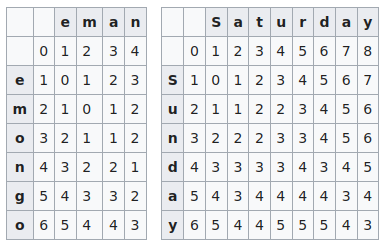

$\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad$ **2. irudia.** Levenshtein distantziaren bi adibide 

Levenhestein distantzia inplementatuko da:
  

In [ ]:
import numpy as np

def levenshtein(seq1, seq2):
    size_x = len(seq1) + 1
    size_y = len(seq2) + 1
    matrix = np.zeros ((size_x, size_y))
    for x in range(size_x):
        matrix [x, 0] = x
    for y in range(size_y):
        matrix [0, y] = y

    for x in range(1, size_x):
        for y in range(1, size_y):
            if seq1[x-1] == seq2[y-1]:
                matrix [x,y] = min(
                    matrix[x-1, y] + 1,
                    matrix[x-1, y-1],
                    matrix[x, y-1] + 1
                )
            else:
                matrix [x,y] = min(
                    matrix[x-1,y] + 1,
                    matrix[x-1,y-1] + 1,
                    matrix[x,y-1] + 1
                )
    return (matrix[size_x - 1, size_y - 1])

Probatuko da ondo funtzionatzen duela:

In [ ]:
print(levenshtein("artritis", "artritis"))
print(levenshtein("arrtritis", "artritis"))
print(levenshtein("artritis", "artri"))

0.0
1.0
3.0


### Gaixotasunak lotu Wikidatarekin
BERTak gaixotasun bat aurkitzen duenean lotura egingo da Wikidatarekin. Horretarako, nik pasa den urtean egin nuen corpusa erabiliko da. Hemen Wikidatako gaixotasunak gordetzen dira informazio askorekin batera.

Lotura hori egiteko Levenshtein distantzia erabiliko da. Aurkitu duen gaixotasuna eta Wikidatako gaixotasun guztien arteko distantzia neurtuko da eta distantzia txikiago edo berdin 2 baldin bada gaixotasun horren Wikipediako linka lortuko da. Bestalde, sintomen kasuan berdina egingo da. Saiatuko da sintoma bakoitza bilatzen gaixotasun moduan Wikidatan ikusteko ea dagoen gaixotasun moduan gordeta eta horrela bada linka lortuko da. Gainera, sintoma bat sintoma moduan agertzen baldin bada Wikidatan markatu da [WikidataSympton] jarriz. Hau da lortu nahi den emaitzaren adibide bat:

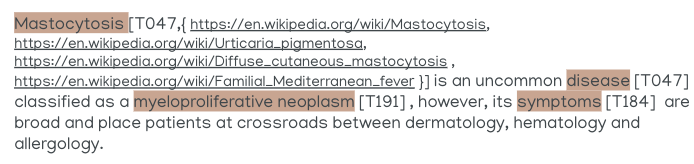

Emaitzak .txt eta .md batean gordeko dira. .md fitxategian gaixotasunak eta sintomak beltzituta daude eta honen egitura txukunagoa da.

Horretarako, emaitza gordeko den direktorioa definitu eta sortuko da:

In [ ]:
emaitza_directory = "./data/solution.txt"
wikidata_directory = "./wikidata/diseases_info_en.csv"
createFile("./data" + emaitza_directory)
disease_pos = 0
also_known_pos = 21
wiki_pos = 19
sympton_pos = 2

Lortuko dira BERTak Z2n iragarritako etiketak. Z2ko BioBERTa erabiliko da honek accuracy onena ematen duelako. Beraz, lehenik eta behin iragarritako etiketak lortuko dira eta fitxategi batean gorde:

In [ ]:
bert=BERTSequenceLabeler(params={"doLowerCase": True, "model_name": "dmis-lab/biobert-v1.1", "embedding_size":768, "label_length": max(tag_vocab.values())+1})
bert.to(device)
bert.load_state_dict(torch.load("ner-biobertZ2_2"))

test_batch_x, test_batch_y = bert.get_batches(testDataZ2_2)
test_precision, test_recall, test_F1 = evaluateF1(bert, test_batch_x, test_batch_y)
print("\nBest Performing Model achieves test accuracy of :  %.3f,%.3f,%.3f" % (test_precision, test_recall, test_F1))


Some weights of BertForMaskedLM were not initialized from the model checkpoint at dmis-lab/biobert-v1.1 and are newly initialized: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Best Performing Model achieves test accuracy of :  0.662,0.571,0.613


In [ ]:
predicted_labels = get_predicted_labels()

[('Generalized', 'B-T047'), ('Epilepsy', 'I-T047'), ('and', 'O'), ('Myoclonic', 'B-T047'), ('Seizures', 'I-T047'), ('in', 'O'), ('22q11.2', 'B-T047'), ('Deletion', 'I-T047'), ('Syndrome', 'I-T047'), ('Prompted', 'O'), ('by', 'O'), ('the', 'O'), ('observations', 'O'), ('of', 'O'), ('juvenile', 'B-T047'), ('myoclonic', 'I-T047'), ('epilepsy', 'I-T047'), ('(', 'O'), ('JME', 'B-T047'), (')', 'O'), ('in', 'O'), ('22q11.2', 'B-T047'), ('deletion', 'I-T047'), ('syndrome', 'I-T047'), ('(', 'O'), ('22q11DS', 'B-T047'), (')', 'O'), ('and', 'O'), ('recurrent', 'O'), ('copy', 'O'), ('number', 'O'), ('variants', 'O'), ('in', 'O'), ('genetic', 'O'), ('generalized', 'B-T047'), ('epilepsy', 'I-T047'), ('(', 'O'), ('GGE', 'B-T047'), (')', 'O'), (',', 'O'), ('we', 'O'), ('searched', 'O'), ('for', 'O'), ('further', 'O'), ('evidence', 'O'), ('supporting', 'O'), ('a', 'O'), ('possible', 'O'), ('correlation', 'O'), ('of', 'O'), ('22q11DS', 'B-T047'), ('with', 'O'), ('GGE', 'B-T047'), ('and', 'O'), ('with', 

In [ ]:
with open("./data/predicted.txt") as file:
  for line in file:
    stringl =  line
    break
lag = stringl.split('], [')
predicted_labels = []
for l in lag:
  lag2 = l.split(",")
  labels = []
  for l2 in lag2:
    s = l2.split("'")
    labels.append(s[1])
  predicted_labels.append(labels)
print((predicted_labels))

[['B-T047', 'I-T047', 'O', 'B-T184', 'I-T184', 'O', 'B-T047', 'B-T047', 'I-T047', 'O', 'O', 'O', 'O', 'O', 'B-T047', 'I-T047', 'I-T047', 'O', 'B-T047', 'O', 'O', 'B-T047', 'B-T047', 'I-T047', 'O', 'B-T047', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-T047', 'I-T047', 'I-T047', 'O', 'B-T047', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-T047', 'O', 'B-T047', 'O', 'O', 'B-T184', 'I-T184', 'O', 'O', 'O', 'B-T060', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-T047', 'O', 'B-T047', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-T047', 'O', 'O', 'B-T047', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-T047', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-T047', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-T047', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-T047', 'O', 'B-T047', 'O', 'O', 'O', 'O', 'O', 'B-T047', 'O', 'O', 'O', 'B-T184', 'I-T184', 'O', 'O', 'O', 'B-T033', 'O', 'B-T047', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-T047'

Orain Wikidatarekin lotura ezarriko da.

In [ ]:
GAIXOTASUN_KOP_TOTALA = 0
GAIXOTASUN_WIKILOTUTA = 0
SINTOMA_KOP_TOTALA = 0
SINTOMA_WIKILOTUTA = 0

def get_wikipedia_link(gaixotasun):
  mycsv = csv.reader(open(wikidata_directory)) #open
  first = True
  links = []
  #iterate the csv file
  for line in mycsv:
    link = line[wiki_pos]
    diseases = []
    if first:
      first = False
    else:
      diseases.append(line[disease_pos])
      diseases.append(line[also_known_pos])
      for disease in diseases:
        dist = levenshtein(gaixotasun.lower(), disease.lower())
        if dist <= 2.0:
          if len(line[wiki_pos]) > 1:
            links.append(line[wiki_pos])
  return links

def  is_sympton(sympton):
  mycsv = csv.reader(open(wikidata_directory)) #open
  first = True
  links = []
  #iterate the csv file
  for line in mycsv:
    link = line[wiki_pos]
    symptons = []
    if first:
      first = False
    else:
      symptons.append(line[disease_pos])
      for s in symptons:
        dist = levenshtein(sympton.lower(), s.lower())
        if dist <= 2.0:
          return True
  return False

def lortu_testua(aurreko_mota, aurreko_entitate):
  if "T047" in aurreko_mota:
    global GAIXOTASUN_KOP_TOTALA
    GAIXOTASUN_KOP_TOTALA += 1 
    link = get_wikipedia_link(aurreko_entitate)
    if link != []:
      global GAIXOTASUN_WIKILOTUTA
      GAIXOTASUN_WIKILOTUTA += 1
    link_string = ', '.join([str(elem) for elem in link])
    testua = "**" + aurreko_entitate +"** ["+aurreko_mota.split("-")[-1]+"] (" + link_string +") "
  elif  "T184" in aurreko_mota:
    global SINTOMA_KOP_TOTALA 
    SINTOMA_KOP_TOTALA += 1
    link = get_wikipedia_link(aurreko_entitate)
    if link != []:
      global SINTOMA_WIKILOTUTA
      SINTOMA_WIKILOTUTA += 1
    link_string = ', '.join([str(elem) for elem in link])
    sintoma_da = is_sympton(aurreko_entitate)
    if sintoma_da:
      testua = "**" + aurreko_entitate +"** ["+aurreko_mota.split("-")[-1]+"][WikidataSympton] (" + link_string +") "
    else:
      testua = "**" + aurreko_entitate +"** ["+aurreko_mota.split("-")[-1]+"] (" + link_string +") "
  else:
    testua = "**" + aurreko_entitate +"** ["+aurreko_mota.split("-")[-1]+"] "
  return testua

def idatzi_predikzioa(predikzioa):
  i, cont = 0, 0
  entitate = ""
  aurreko_entitatea, aurreko_mota = "", ""
  testua = ""
  sartu = False
  with open(test_BIO_directory_Z2_2) as file:
    for line in file:
      cols=line.rstrip().split("\t")
      luzera = len(predikzioa[i])
      if luzera == cont and len(cols)==1: #irakurri da kasu bat
        i += 1
        cont = 0
        idatzi_kasua(emaitza_directory, "\n\n")
      elif luzera != cont:
        entitate_mota = predikzioa[i][cont]
        if "B" in entitate_mota: 
          if sartu:
            sartu = False
            testua = lortu_testua(aurreko_mota, aurreko_entitate)
            idatzi_kasua(emaitza_directory, testua)        
          entitate = ""
          entitate +=  " "  + cols[0] 
          aurreko_entitate = entitate
          aurreko_mota = entitate_mota
          sartu = True
        elif "I" in entitate_mota:
          entitate +=  " "  + cols[0]
          aurreko_entitate = entitate
          sartu = True
        else:
          if sartu:
            sartu = False
            testua = lortu_testua(aurreko_mota, aurreko_entitate)
            idatzi_kasua(emaitza_directory, testua)
          testua =  " "  + cols[0] 
          idatzi_kasua(emaitza_directory, testua)
        cont += 1


In [ ]:
idatzi_predikzioa(predicted_labels)

### Ebaluazioa
Ebaluazio egieko alde batetik erabiliko da Z2n NER ebaluatzeko erabili dena, hau da, F1, precision eta recall. Eta beste alde batetik ,kalkulatuko da zeintzuk diren gaixotasunen eta sintomen kasuan estaldura Wikidatan. Horretarako kalkulatuko da zenbat gaixotasun detektatu dituen BERTak eta horietatik zenbat dauden Wikidatan. Sintomen kasuan berdina egingo da.

Z2ko emaitzak zeinzuk diren badakizkigu, hortaz, bakarrik estaldura kalkulatuko da:

Lortu eta gordeko dira iragarri diren gaixotasun eta sintoma guztiak, eta Wikidatarekin lotzea lortu diren gaixotasun eta sintoma kopurua.

In [ ]:
print(GAIXOTASUN_KOP_TOTALA)
print(GAIXOTASUN_WIKILOTUTA )
print(SINTOMA_KOP_TOTALA )
print(SINTOMA_WIKILOTUTA )

2298
1057
346
45


In [ ]:
idatzi_kasua("./data/predicted.txt", str(GAIXOTASUN_KOP_TOTALA)+" GAIXOTASUN_KOP_TOTALA \n")
idatzi_kasua("./data/predicted.txt", str(GAIXOTASUN_WIKILOTUTA)+" GAIXOTASUN_WIKILOTUTA \n")
idatzi_kasua("./data/predicted.txt", str(SINTOMA_KOP_TOTALA)+" SINTOMA_KOP_TOTALA \n")
idatzi_kasua("./data/predicted.txt", str(SINTOMA_WIKILOTUTA)+" SINTOMA_WIKILOTUTA \n")

Orain kalkulatuko da estaldura.  
* Gaixotasun kasuan honela kalkulatuko da: $\frac{GAIXOTASUN\_WIKILOTURA}{GAIXOTASUN\_KOP\_TOTALA}$  

$\quad$

* Sintomen kasuan, aldiz, honela kalkulatuko da: $\frac{SINTOMA\_WIKILOTURA}{SINTOMA\_KOP\_TOTALA}$

In [ ]:
GAIXOTASUN_KOP_TOTALA = 2298
GAIXOTASUN_WIKILOTURA = 1057
SINTOMA_KOP_TOTALA = 346
SINTOMA_WIKILOTURA = 45

estaldura_gaixotasuna = (GAIXOTASUN_WIKILOTURA/GAIXOTASUN_KOP_TOTALA) 
estaldura_sintoma = (SINTOMA_WIKILOTURA/SINTOMA_KOP_TOTALA) 

print("Gaixotasunen estaldura Wikidatan hurrengoa da: "+ str(estaldura_gaixotasuna))
print("Sintomen estaldura Wikidatan hurrengo da: " +str(estaldura_sintoma))

Gaixotasunen estaldura Wikidatan hurrengoa da: 0.4599651871192341
Sintomen estaldura Wikidatan hurrengo da: 0.13005780346820808


### Ondorioak
Ikus daitekenez, gaixotasunen estaldura sintomena baina nabarmen altuagoa da. Honek zentzua dauka sintomak bilatzen ari direlako gaixotasun  moduan. Bestalde, gaixotasun estaldura ez da oso altua ez baita ailegatzen %50ra.